# Modelos VAR: ITAEE estatal y Tipos de Cambio

Se estiman **5 modelos VAR** (uno por estado). Cada VAR incluye 13 variables:
- `ITAEE_Nacional` + `ITAEE_{Estado}` + 11 tipos de cambio vs MXN.

Contenido:
1. Carga de datos y definiciones
2. Pruebas de estacionariedad (ADF & KPSS)
3. Estimación VAR por estado (selección de rezagos, diagnósticos, Granger, IRF, FEVD)
4. Tabla resumen comparativa

## 1. Setup & Carga de Datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*kpss.*")

sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 150
plt.rcParams["savefig.bbox"] = "tight"

FIG_DIR = os.path.join(os.path.dirname(os.getcwd()), "figures")
os.makedirs(FIG_DIR, exist_ok=True)

# --- Load data ---
df = pd.read_csv(
    os.path.join(os.path.dirname(os.getcwd()), "data", "dataset.csv"),
    index_col=0,
    parse_dates=False,
)
df.index = pd.PeriodIndex(df.index, freq="Q").to_timestamp()
df.index.name = "date"

# --- Define variable groups ---
states = ["Aguascalientes", "Durango", "Querétaro", "San Luis Potosí", "Zacatecas"]
fx_cols = [c for c in df.columns if c.startswith("FX_")]

print(f"Dataset: {df.shape[0]} trimestres × {df.shape[1]} variables")
print(f"Periodo: {df.index[0].date()} a {df.index[-1].date()}")
print(f"Estados: {states}")
print(f"FX ({len(fx_cols)}): {[c.replace('FX_','') for c in fx_cols]}")

Dataset: 70 trimestres × 17 variables
Periodo: 2007-04-01 a 2024-10-01
Estados: ['Aguascalientes', 'Durango', 'Querétaro', 'San Luis Potosí', 'Zacatecas']
FX (11): ['USD', 'CAD', 'BRL', 'JPY', 'CNY', 'COP', 'CLP', 'RUB', 'ILS', 'EUR', 'INR']


## 2. Pruebas de Estacionariedad (ADF & KPSS)

In [2]:
def adf_test(series, name):
    """Run ADF test, return dict with key results."""
    result = adfuller(series.dropna(), autolag="AIC")
    return {
        "Variable": name,
        "ADF Stat": round(result[0], 4),
        "ADF p-value": round(result[1], 4),
        "ADF Lags": result[2],
    }


def kpss_test(series, name):
    """Run KPSS test (trend), return dict."""
    result = kpss(series.dropna(), regression="ct", nlags="auto")
    return {
        "Variable": name,
        "KPSS Stat": round(result[0], 4),
        "KPSS p-value": round(result[1], 4),
        "KPSS Lags": result[2],
    }


# All 17 series to test
all_cols = ["ITAEE_Nacional"] + [f"ITAEE_{s}" for s in states] + fx_cols

# --- Levels ---
rows_level = []
for col in all_cols:
    adf = adf_test(df[col], col)
    kp = kpss_test(df[col], col)
    row = {**adf, **{k: v for k, v in kp.items() if k != "Variable"}}
    row["Stationary (ADF)"] = "Yes" if adf["ADF p-value"] < 0.05 else "No"
    row["Stationary (KPSS)"] = "Yes" if kp["KPSS p-value"] > 0.05 else "No"
    rows_level.append(row)

df_level = pd.DataFrame(rows_level).set_index("Variable")
print("=== Pruebas en NIVELES ===")
display(df_level)

=== Pruebas en NIVELES ===


/var/folders/sy/qdyc7ynx1db2l4pvs78lyhnm0000gn/T/ipykernel_97707/1105613042.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression="ct", nlags="auto")
/var/folders/sy/qdyc7ynx1db2l4pvs78lyhnm0000gn/T/ipykernel_97707/1105613042.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression="ct", nlags="auto")
/var/folders/sy/qdyc7ynx1db2l4pvs78lyhnm0000gn/T/ipykernel_97707/1105613042.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression="ct", nlags="auto")
/var/folders/sy/qdyc7ynx1db2l4pvs78lyhnm0000gn/T/ipykernel

ADF Stat  ADF p-value  ADF Lags  KPSS Stat  \
Variable                                                            
ITAEE_Nacional          -0.4483       0.9017         3     0.1385   
ITAEE_Aguascalientes    -1.0127       0.7486         4     0.2848   
ITAEE_Durango           -1.7331       0.4141         8     0.2645   
ITAEE_Querétaro         -1.3298       0.6154         3     0.2590   
ITAEE_San Luis Potosí   -0.7370       0.8369         2     0.1662   
ITAEE_Zacatecas         -1.6343       0.4653         3     0.3549   
FX_USD                  -1.3239       0.6182         0     0.1572   
FX_CAD                  -2.2162       0.2004         3     0.1279   
FX_BRL                  -0.8246       0.8118         1     0.1141   
FX_JPY                  -2.5089       0.1133         1     0.1438   
FX_CNY                  -1.9275       0.3192         0     0.1953   
FX_COP                  -7.5030       0.0000         0     0.1975   
FX_CLP                  -7.1292       0.0000         0     0.2509   
FX_RUB                  -1.2852       0.6359         2     0.0568   
FX_ILS                  -1.4679       0.5493         1     0.1373   
FX_EUR                  -1.8808       0.3411         1     0.1348   
FX_INR                  -2.4755       0.1215         4     0.1243   

                       KPSS p-value  KPSS Lags Stationary (ADF)  \
Variable                                                          
ITAEE_Nacional               0.0639          4               No   
ITAEE_Aguascalientes         0.0100          4               No   
ITAEE_Durango                0.0100          4               No   
ITAEE_Querétaro              0.0100          4               No   
ITAEE_San Luis Potosí        0.0332          4               No   
ITAEE_Zacatecas              0.0100          0               No   
FX_USD                       0.0407          5               No   
FX_CAD                       0.0835          5               No   
FX_BRL                       0.1000          4               No   
FX_JPY                       0.0540          5               No   
FX_CNY                       0.0177          5               No   
FX_COP                       0.0169          1              Yes   
FX_CLP                       0.0100          2              Yes   
FX_RUB                       0.1000          1               No   
FX_ILS                       0.0662          5               No   
FX_EUR                       0.0708          5               No   
FX_INR                       0.0901          5               No   

                      Stationary (KPSS)  
Variable                                 
ITAEE_Nacional                      Yes  
ITAEE_Aguascalientes                 No  
ITAEE_Durango                        No  
ITAEE_Querétaro                      No  
ITAEE_San Luis Potosí                No  
ITAEE_Zacatecas                      No  
FX_USD                               No  
FX_CAD                              Yes  
FX_BRL                              Yes  
FX_JPY                              Yes  
FX_CNY                               No  
FX_COP                               No  
FX_CLP                               No  
FX_RUB                              Yes  
FX_ILS                              Yes  
FX_EUR                              Yes  
FX_INR                              Yes

In [3]:
# --- Log-differences ---
df_log = np.log(df[all_cols])
df_dlog = df_log.diff().dropna()
df_dlog.columns = [f"dlog_{c}" for c in all_cols]

rows_diff = []
for i, col in enumerate(all_cols):
    s = df_dlog.iloc[:, i]
    adf = adf_test(s, col)
    kp = kpss_test(s, col)
    row = {**adf, **{k: v for k, v in kp.items() if k != "Variable"}}
    row["Stationary (ADF)"] = "Yes" if adf["ADF p-value"] < 0.05 else "No"
    row["Stationary (KPSS)"] = "Yes" if kp["KPSS p-value"] > 0.05 else "No"
    rows_diff.append(row)

df_diff = pd.DataFrame(rows_diff).set_index("Variable")
print("=== Pruebas en LOG-DIFERENCIAS ===")
display(df_diff)

print("\nTodas las series son estacionarias en log-diferencias:",
      all(df_diff["Stationary (ADF)"] == "Yes"))

/var/folders/sy/qdyc7ynx1db2l4pvs78lyhnm0000gn/T/ipykernel_97707/1105613042.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression="ct", nlags="auto")
/var/folders/sy/qdyc7ynx1db2l4pvs78lyhnm0000gn/T/ipykernel_97707/1105613042.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression="ct", nlags="auto")
/var/folders/sy/qdyc7ynx1db2l4pvs78lyhnm0000gn/T/ipykernel_97707/1105613042.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression="ct", nlags="auto")
/var/folders/sy/qdyc7ynx1db2l4pvs78lyhnm0000gn/T/ipykernel

=== Pruebas en LOG-DIFERENCIAS ===


ADF Stat  ADF p-value  ADF Lags  KPSS Stat  \
Variable                                                            
ITAEE_Nacional          -8.1368       0.0000         2     0.0767   
ITAEE_Aguascalientes    -6.2490       0.0000         3     0.3240   
ITAEE_Durango           -2.6213       0.0887         7     0.1827   
ITAEE_Querétaro         -7.1898       0.0000         2     0.2204   
ITAEE_San Luis Potosí   -8.2353       0.0000         1     0.0619   
ITAEE_Zacatecas        -13.2793       0.0000         2     0.0892   
FX_USD                  -7.0006       0.0000         0     0.0527   
FX_CAD                  -3.7148       0.0039         2     0.0474   
FX_BRL                  -6.3202       0.0000         0     0.0704   
FX_JPY                  -6.7757       0.0000         0     0.0631   
FX_CNY                  -6.8301       0.0000         0     0.0375   
FX_COP                  -6.7610       0.0000         4     0.1986   
FX_CLP                  -5.1178       0.0000         8     0.4166   
FX_RUB                  -8.9939       0.0000         1     0.3525   
FX_ILS                  -7.0976       0.0000         0     0.0805   
FX_EUR                  -7.1206       0.0000         0     0.0504   
FX_INR                  -6.4304       0.0000         0     0.0754   

                       KPSS p-value  KPSS Lags Stationary (ADF)  \
Variable                                                          
ITAEE_Nacional               0.1000         10              Yes   
ITAEE_Aguascalientes         0.0100         45              Yes   
ITAEE_Durango                0.0225         30               No   
ITAEE_Querétaro              0.0100         37              Yes   
ITAEE_San Luis Potosí        0.1000          8              Yes   
ITAEE_Zacatecas              0.1000         13              Yes   
FX_USD                       0.1000          3              Yes   
FX_CAD                       0.1000          3              Yes   
FX_BRL                       0.1000          1              Yes   
FX_JPY                       0.1000          3              Yes   
FX_CNY                       0.1000          2              Yes   
FX_COP                       0.0165         29              Yes   
FX_CLP                       0.0100         57              Yes   
FX_RUB                       0.0100         48              Yes   
FX_ILS                       0.1000          0              Yes   
FX_EUR                       0.1000          1              Yes   
FX_INR                       0.1000          2              Yes   

                      Stationary (KPSS)  
Variable                                 
ITAEE_Nacional                      Yes  
ITAEE_Aguascalientes                 No  
ITAEE_Durango                        No  
ITAEE_Querétaro                      No  
ITAEE_San Luis Potosí               Yes  
ITAEE_Zacatecas                     Yes  
FX_USD                              Yes  
FX_CAD                              Yes  
FX_BRL                              Yes  
FX_JPY                              Yes  
FX_CNY                              Yes  
FX_COP                               No  
FX_CLP                               No  
FX_RUB                               No  
FX_ILS                              Yes  
FX_EUR                              Yes  
FX_INR                              Yes


Todas las series son estacionarias en log-diferencias: False


## 3. Estimación VAR por Estado

Para cada estado se estima un VAR con 13 variables (en log-diferencias):
- `ITAEE_Nacional`, `ITAEE_{Estado}`, y 11 tipos de cambio.

In [4]:
# Prepare the log-differenced data with original-style column names
df_var = np.log(df[all_cols]).diff().dropna()

# Store all results
results = {}  # state -> dict with model, granger, etc.

MAX_LAGS = 3  # max lags to consider (13 vars, ~69 obs → max estimable is 3)

  ESTADO: Aguascalientes


/Users/marionomics/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)



--- (a) Selección de rezagos ---
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -78.35     -77.92*  9.427e-35*     -78.18*
1      -77.22      -71.18   3.167e-34      -74.83
2      -77.21      -65.56   5.706e-34      -72.61
3     -80.07*      -62.82   2.066e-34      -73.26
-------------------------------------------------

→ Rezago seleccionado (AIC): p = 3

--- (b) VAR(3) estimado ---
   Observaciones usadas: 66
   Variables: 3 rezagos × 13 variables

--- (c) Diagnósticos ---
Durbin-Watson por ecuación:
   Nacional            : 1.946
   Aguascalientes      : 2.100
   USD                 : 2.161
   CAD                 : 2.152
   BRL                 : 2.078
   JPY                 : 2.294
   CNY                 : 2.235
   COP                 : 2.204
   CLP                 : 2.081
   RUB                 : 2.160
   ILS                 : 1.913
   EUR                 : 1.989
   INR  

F-stat  p-value Significant (5%)
FX                                   
USD   1.022   0.3896               No
CAD   0.662   0.5788               No
BRL   0.309   0.8191               No
JPY   0.748   0.5278               No
CNY   1.527   0.2168               No
COP   0.109   0.9545               No
CLP   0.616   0.6076               No
RUB   0.266   0.8496               No
ILS   0.284   0.8366               No
EUR   0.896   0.4486               No
INR   1.051   0.3768               No

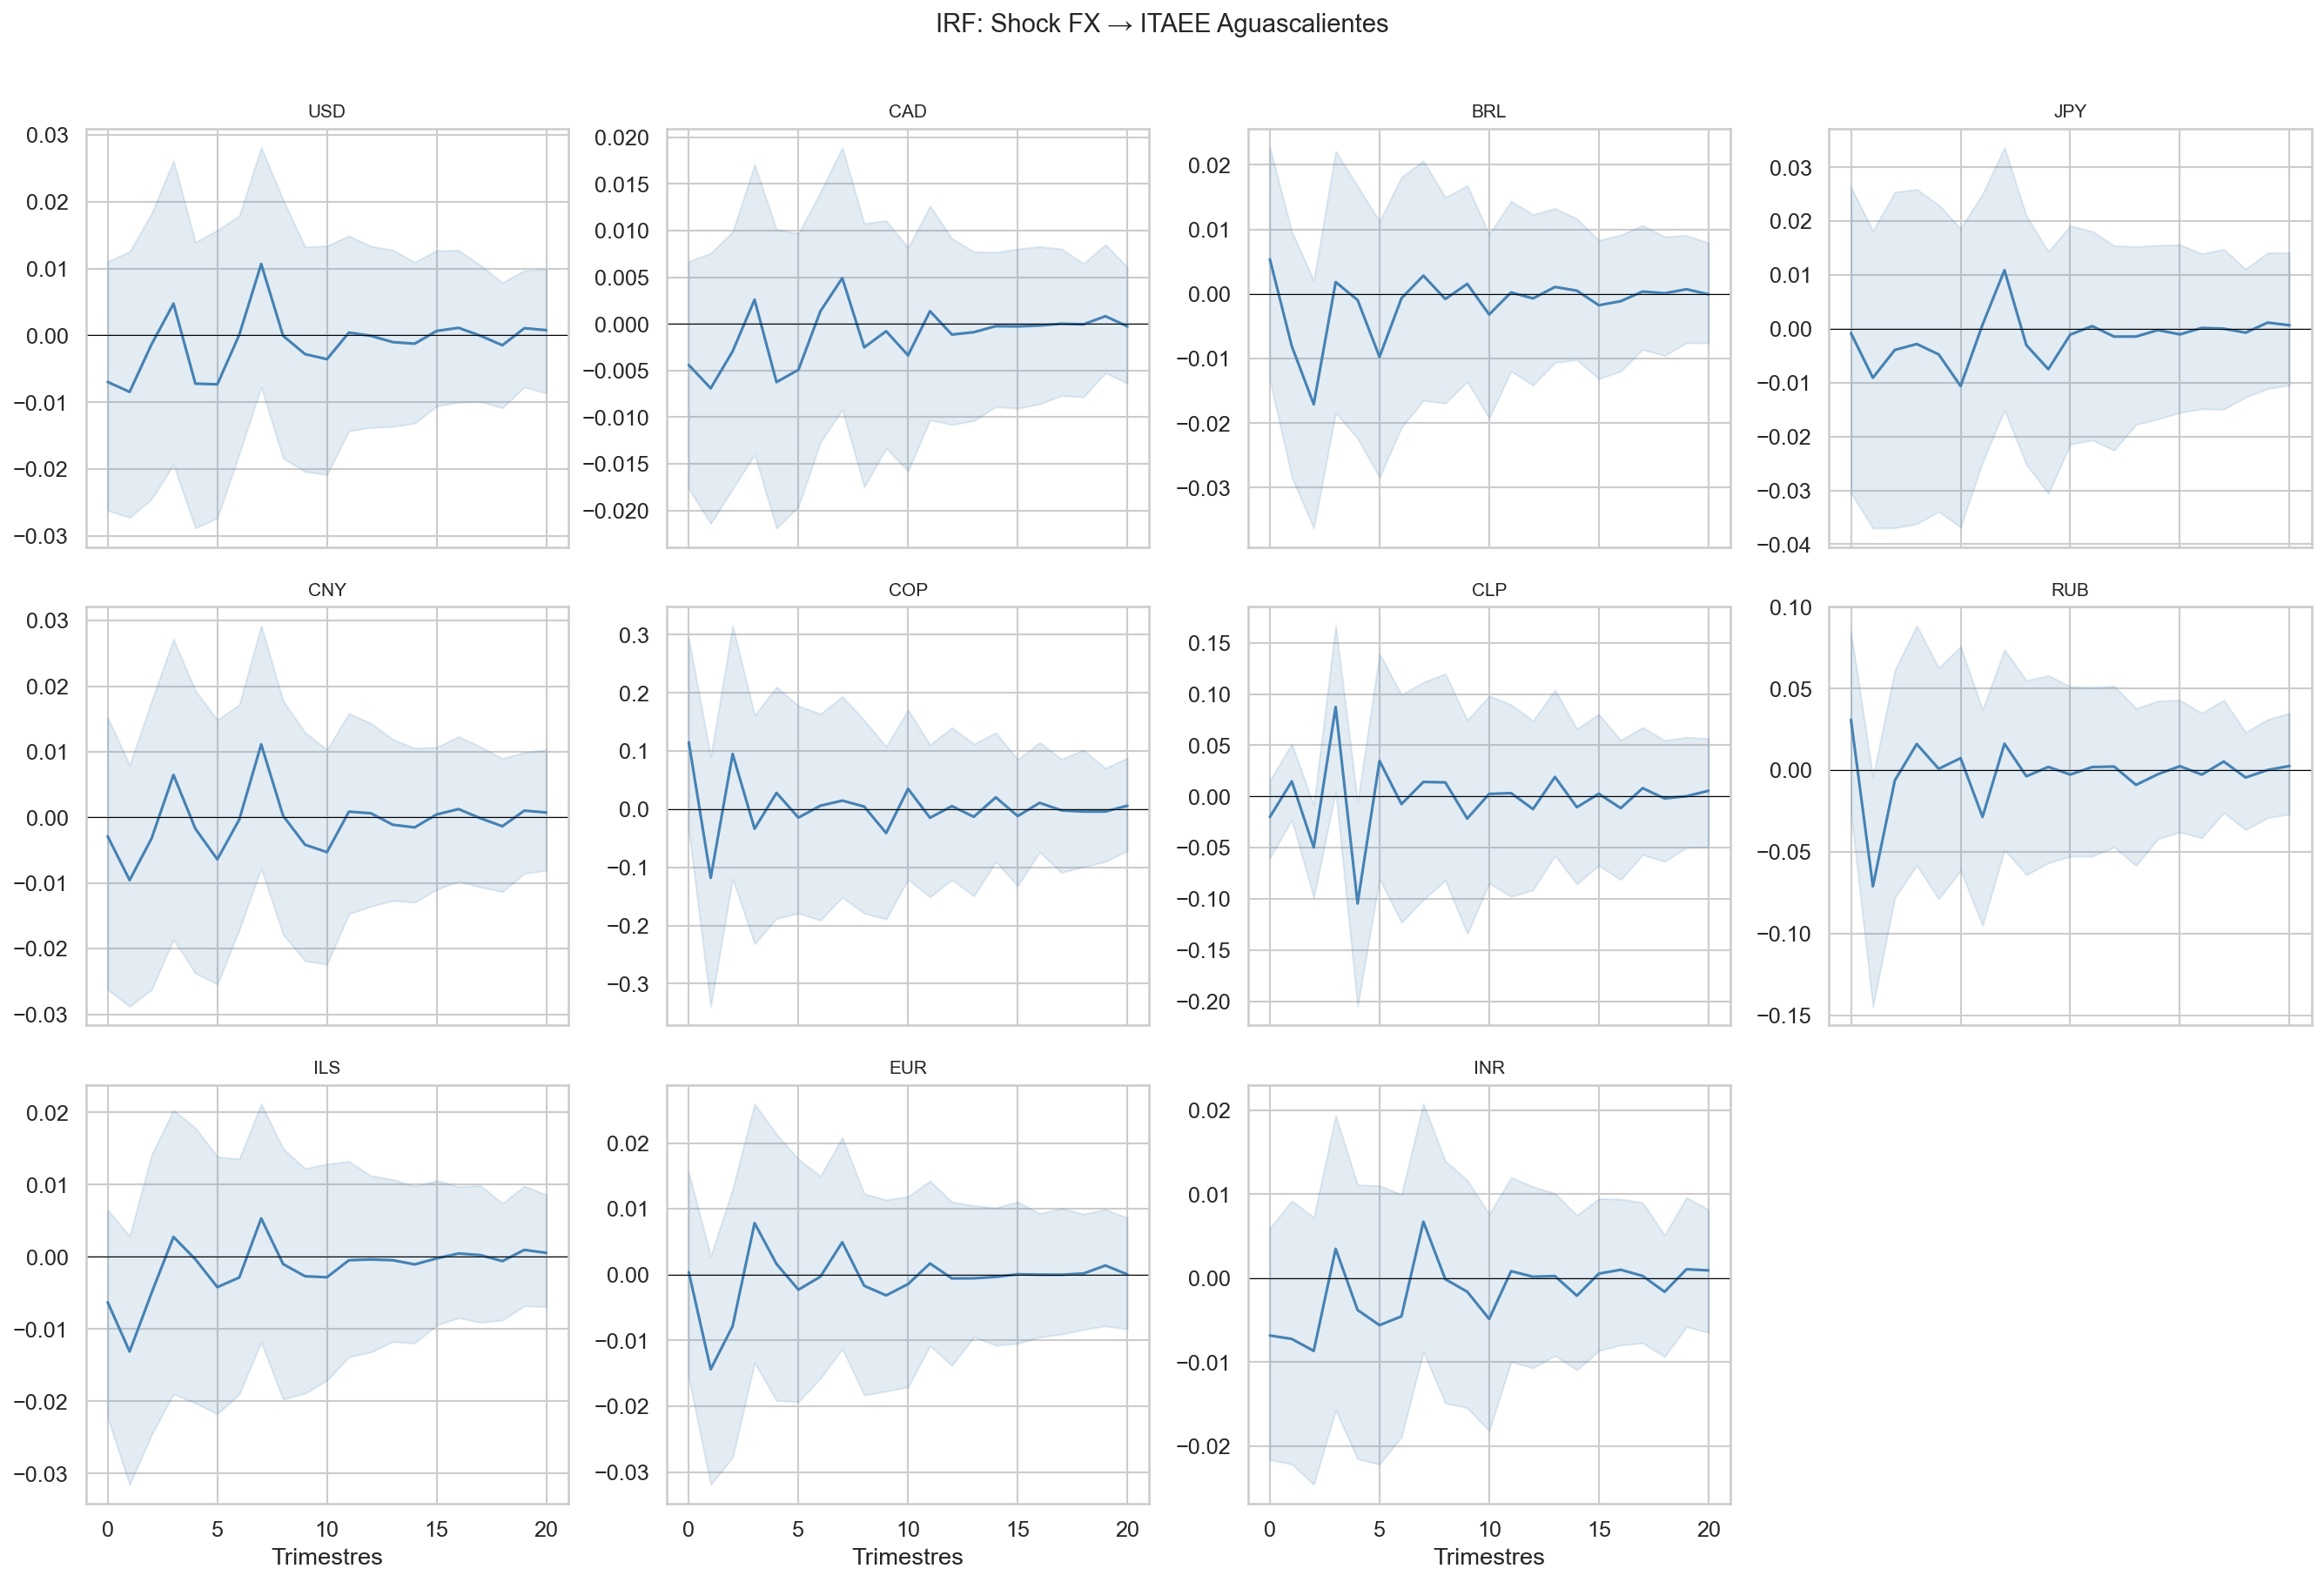

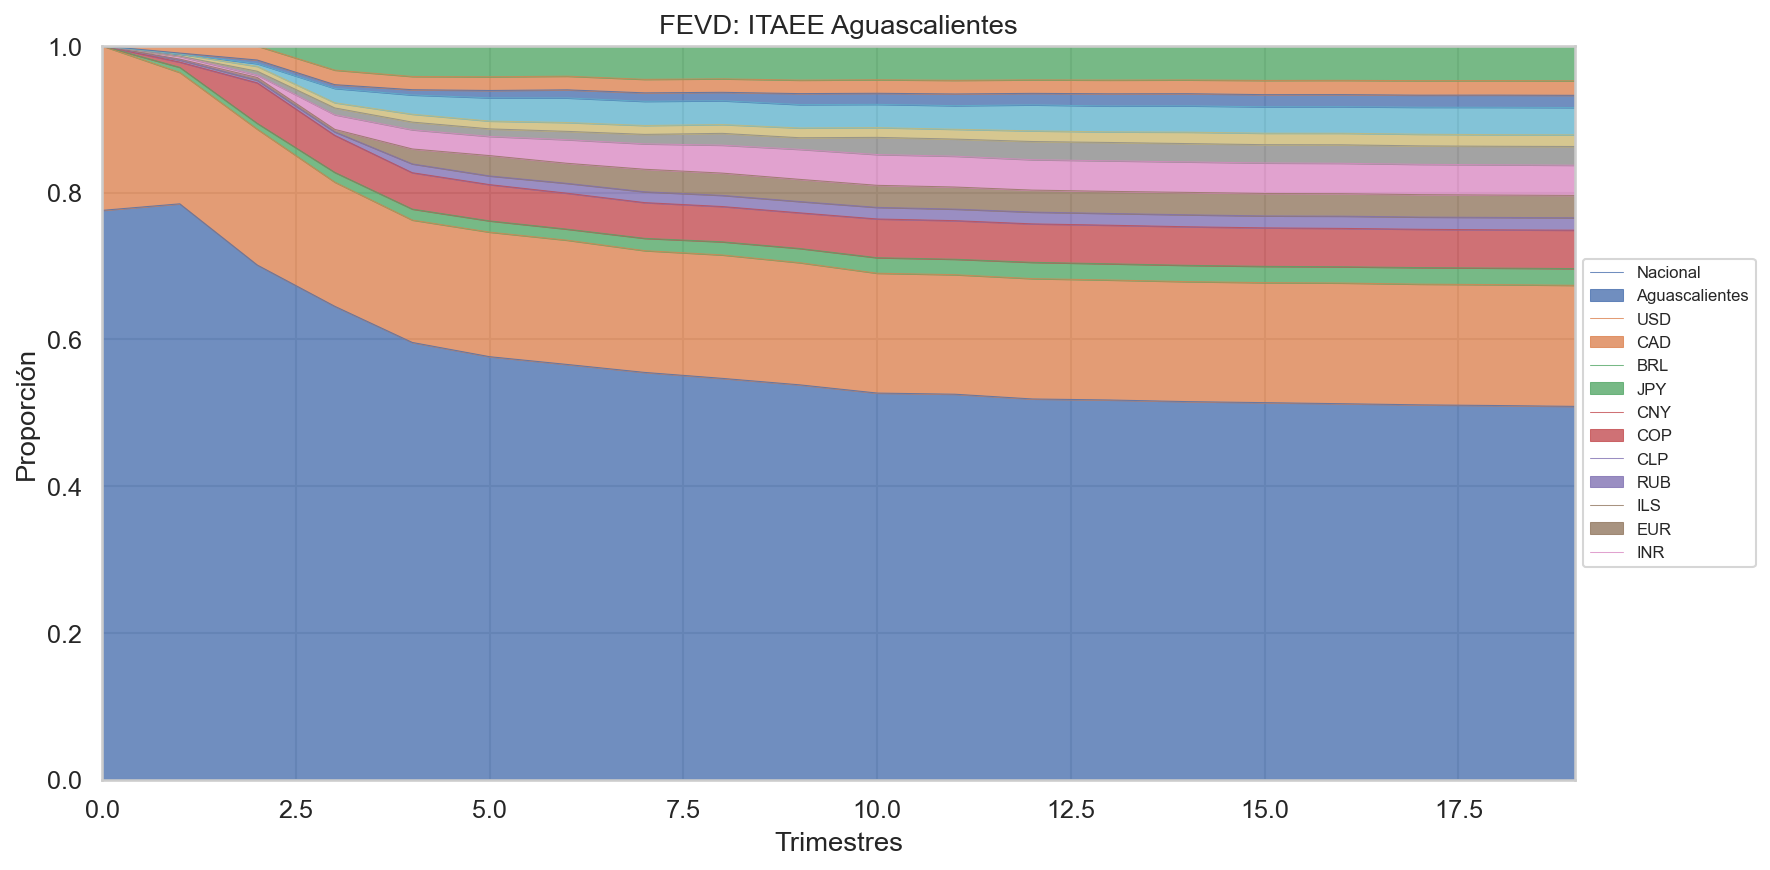


  ESTADO: Durango

--- (a) Selección de rezagos ---
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -78.49     -78.06*   8.161e-35     -78.32*
1      -77.60      -71.56   2.164e-34      -75.22
2      -77.81      -66.17   3.114e-34      -73.21
3     -81.05*      -63.80  7.806e-35*      -74.23
-------------------------------------------------

→ Rezago seleccionado (AIC): p = 3

--- (b) VAR(3) estimado ---
   Observaciones usadas: 66
   Variables: 3 rezagos × 13 variables

--- (c) Diagnósticos ---
Durbin-Watson por ecuación:
   Nacional            : 2.119
   Durango             : 2.103
   USD                 : 2.205
   CAD                 : 2.316
   BRL                 : 2.089
   JPY                 : 2.376
   CNY                 : 2.394
   COP                 : 2.231
   CLP                 : 1.925
   RUB                 : 2.238
   ILS                 : 2.153
   EUR              

/Users/marionomics/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


F-stat  p-value Significant (5%)
FX                                   
USD   2.689   0.0544               No
CAD   1.553   0.2104               No
BRL   0.207   0.8914               No
JPY   0.955   0.4201               No
CNY   1.454   0.2364               No
COP   0.422   0.7376               No
CLP   0.364   0.7795               No
RUB   0.050   0.9851               No
ILS   1.016   0.3921               No
EUR   0.944   0.4252               No
INR   3.941   0.0125              Yes

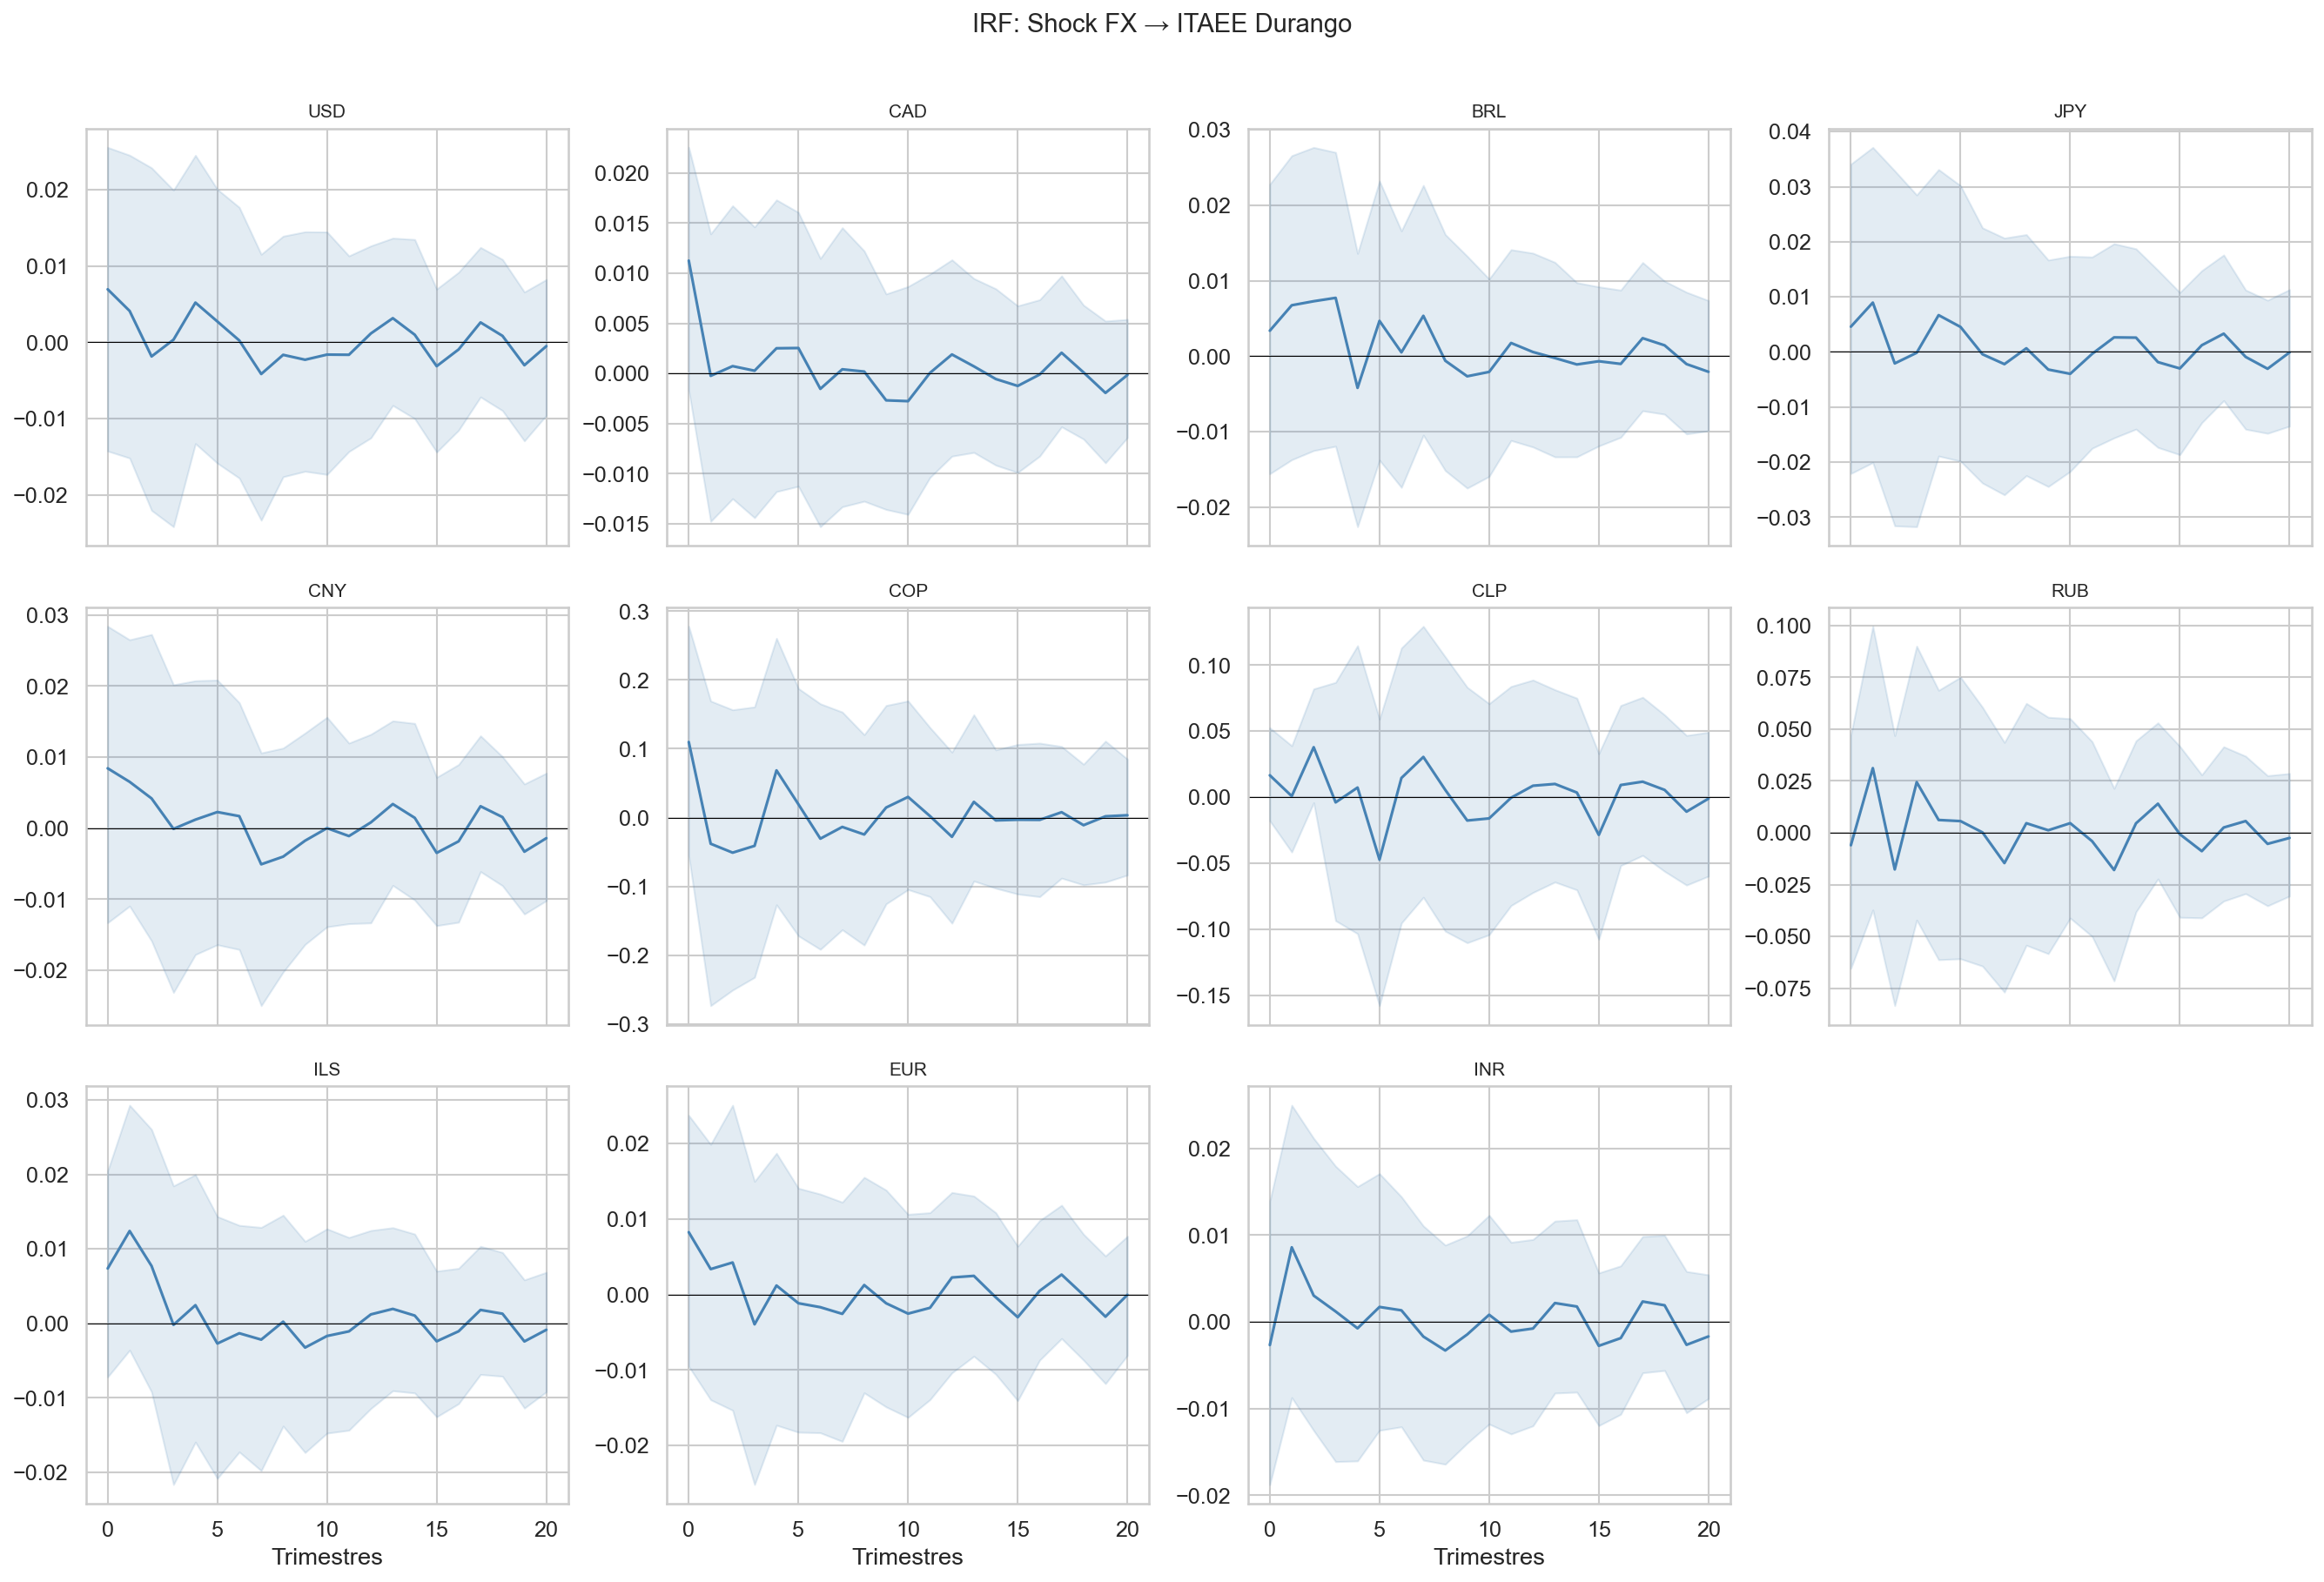

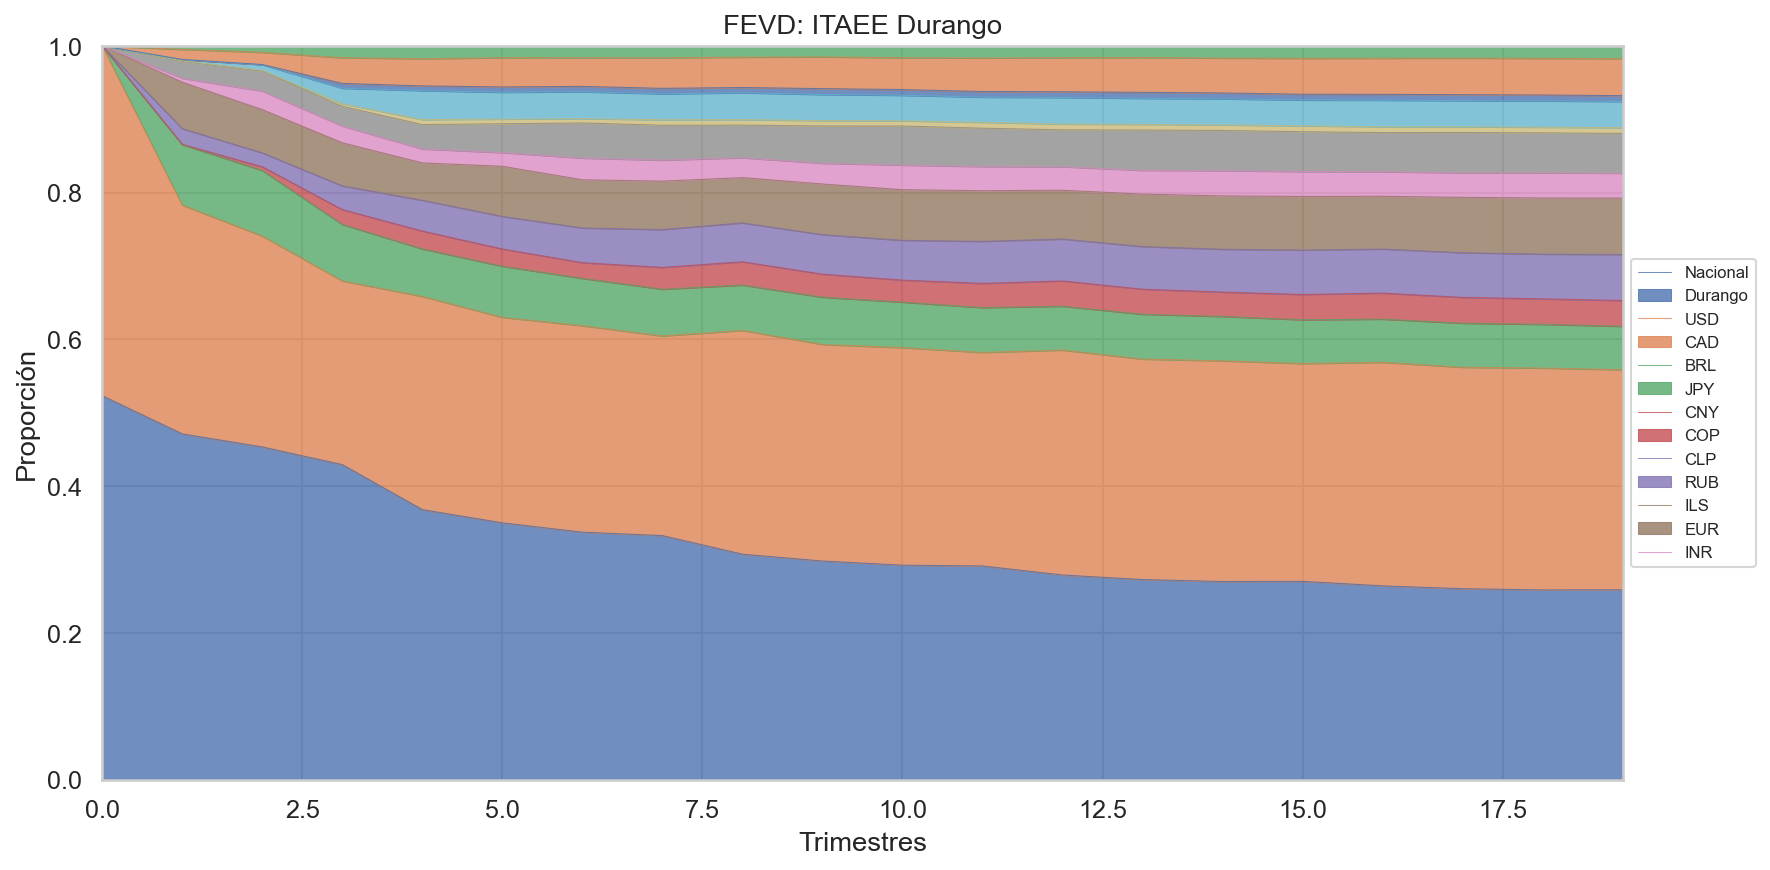


  ESTADO: Querétaro

--- (a) Selección de rezagos ---
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -78.84     -78.40*   5.781e-35     -78.67*
1      -78.45      -72.42   9.214e-35      -76.07
2      -79.20      -67.56   7.781e-35      -74.60
3     -82.34*      -65.09  2.136e-35*      -75.53
-------------------------------------------------

→ Rezago seleccionado (AIC): p = 3

--- (b) VAR(3) estimado ---
   Observaciones usadas: 66
   Variables: 3 rezagos × 13 variables

--- (c) Diagnósticos ---
Durbin-Watson por ecuación:
   Nacional            : 2.074
   Querétaro           : 2.077
   USD                 : 2.260
   CAD                 : 2.181
   BRL                 : 1.789
   JPY                 : 2.364
   CNY                 : 2.314
   COP                 : 2.212
   CLP                 : 2.005
   RUB                 : 2.269
   ILS                 : 1.980
   EUR            

/Users/marionomics/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


F-stat  p-value Significant (5%)
FX                                   
USD   1.524   0.2176               No
CAD   0.177   0.9115               No
BRL   0.493   0.6883               No
JPY   1.139   0.3409               No
CNY   1.390   0.2546               No
COP   0.043   0.9878               No
CLP   0.266   0.8497               No
RUB   0.345   0.7927               No
ILS   0.712   0.5488               No
EUR   1.045   0.3793               No
INR   1.010   0.3949               No

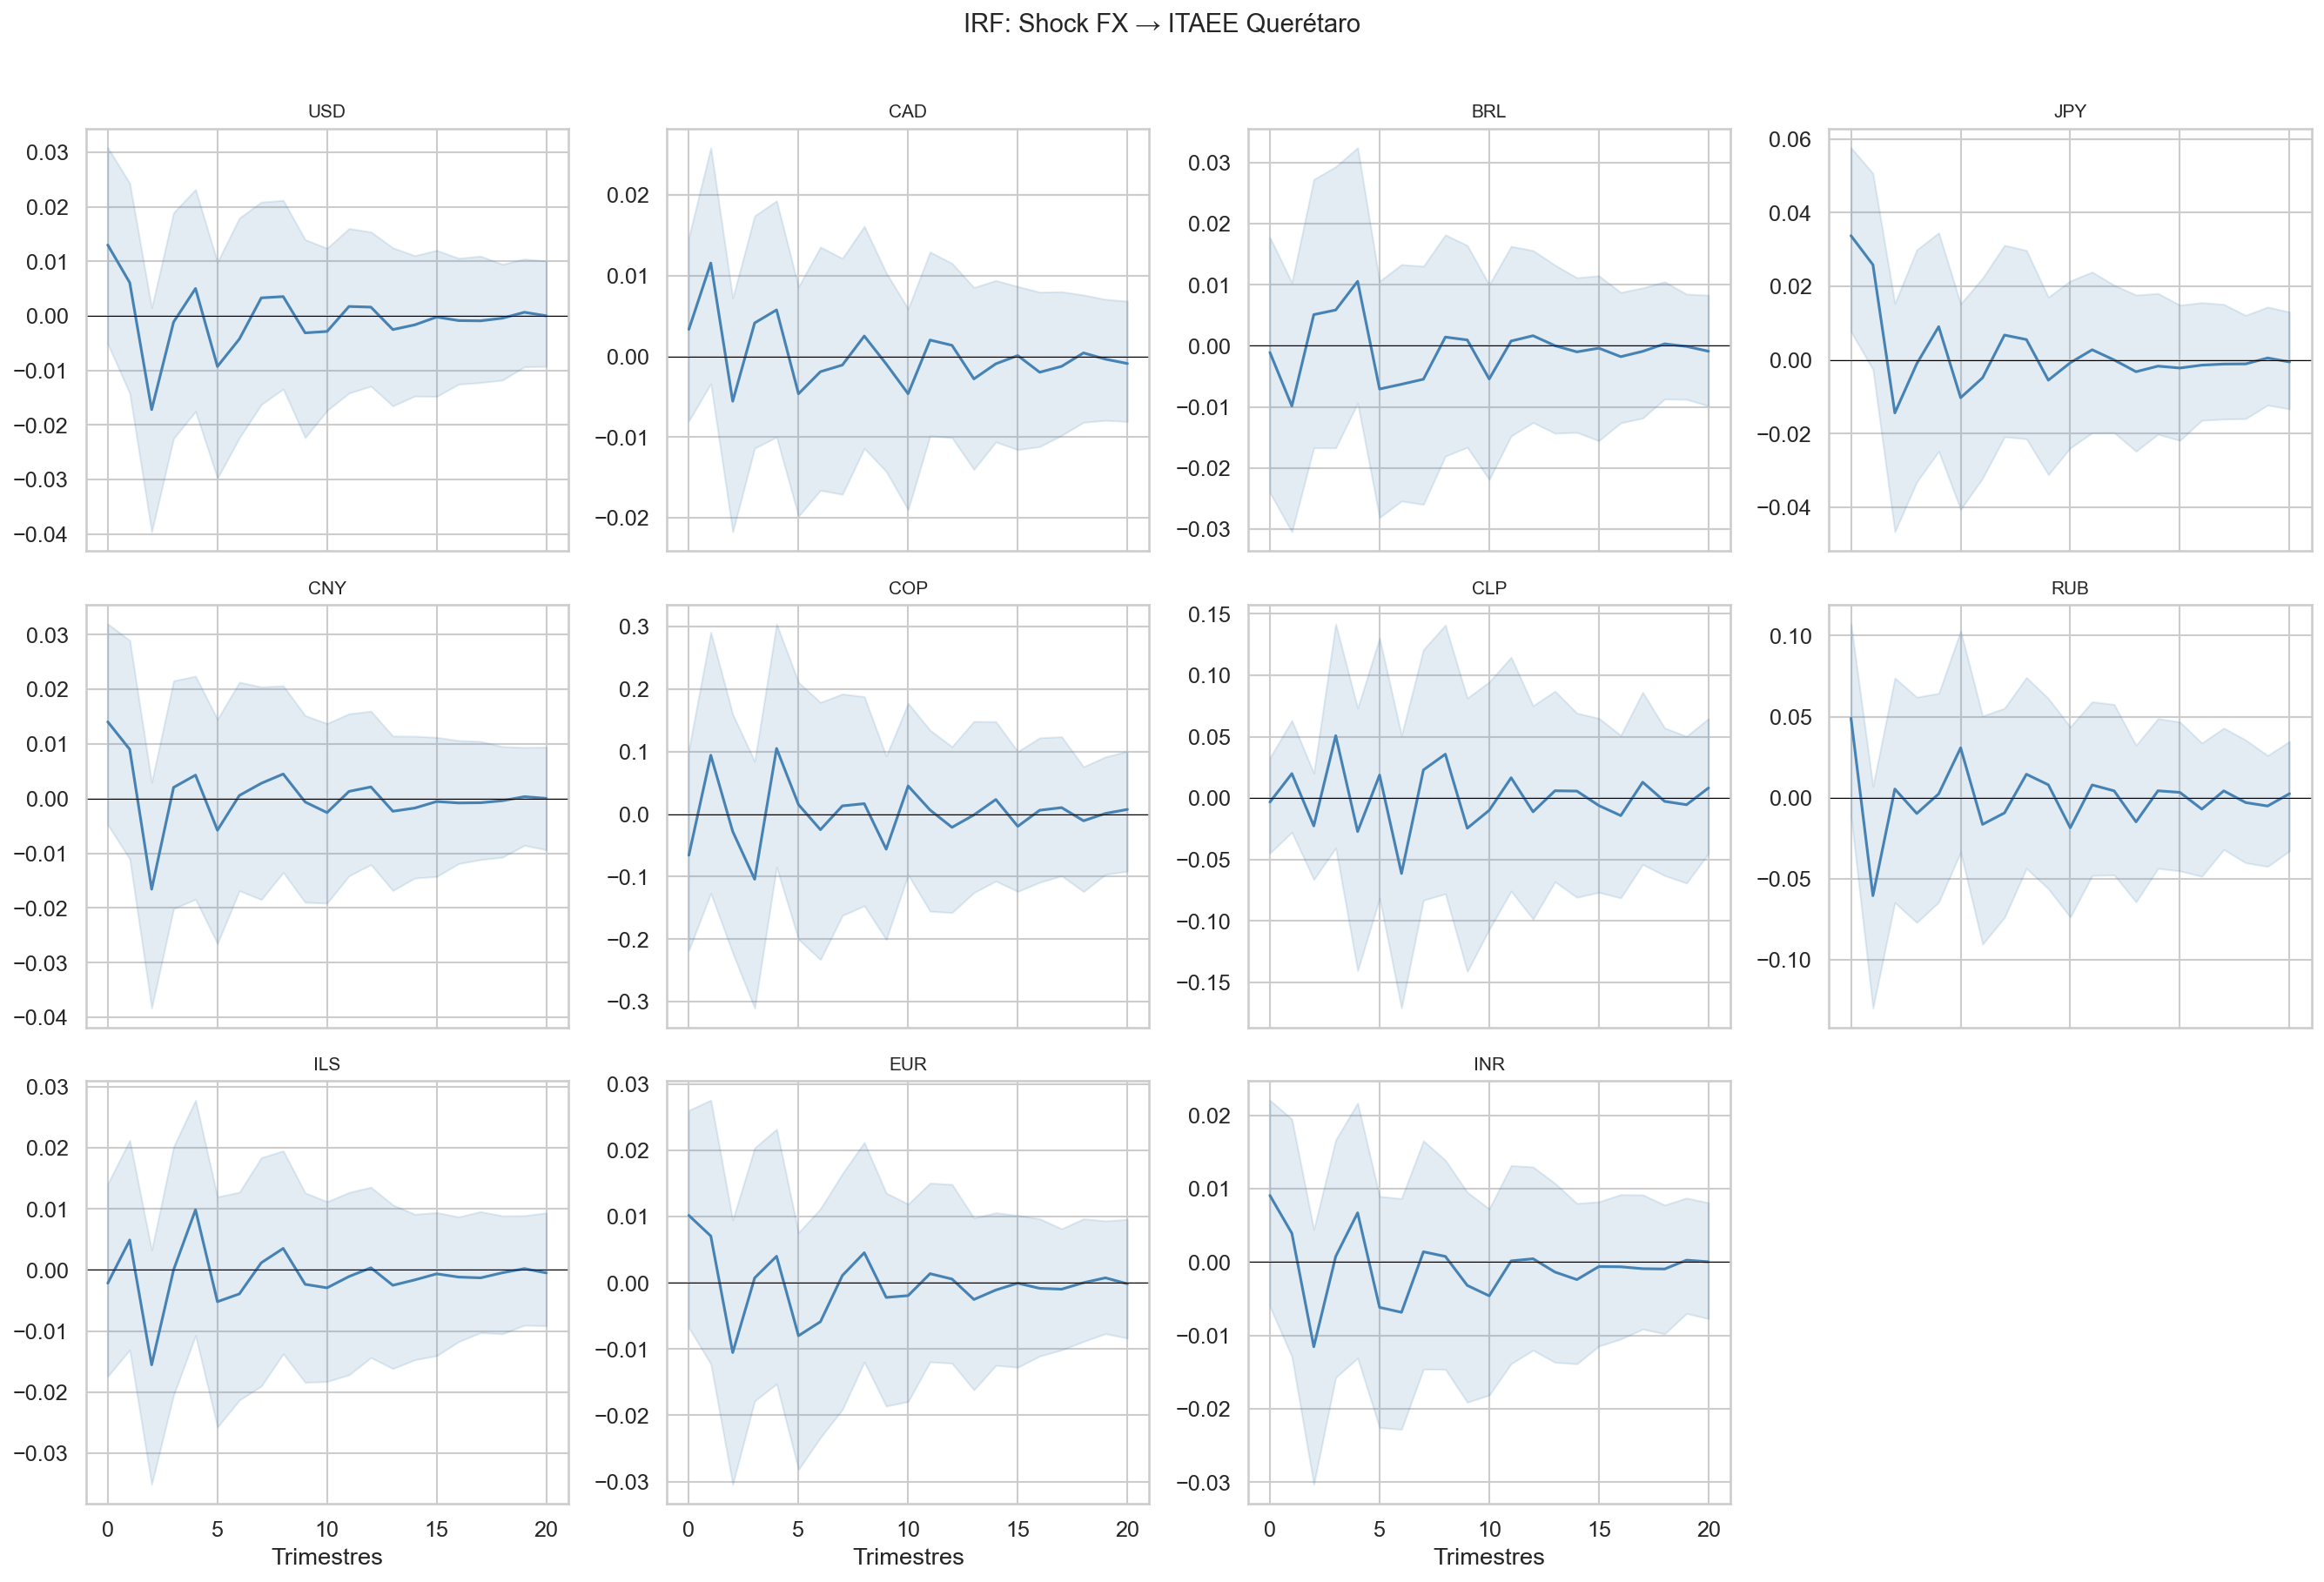

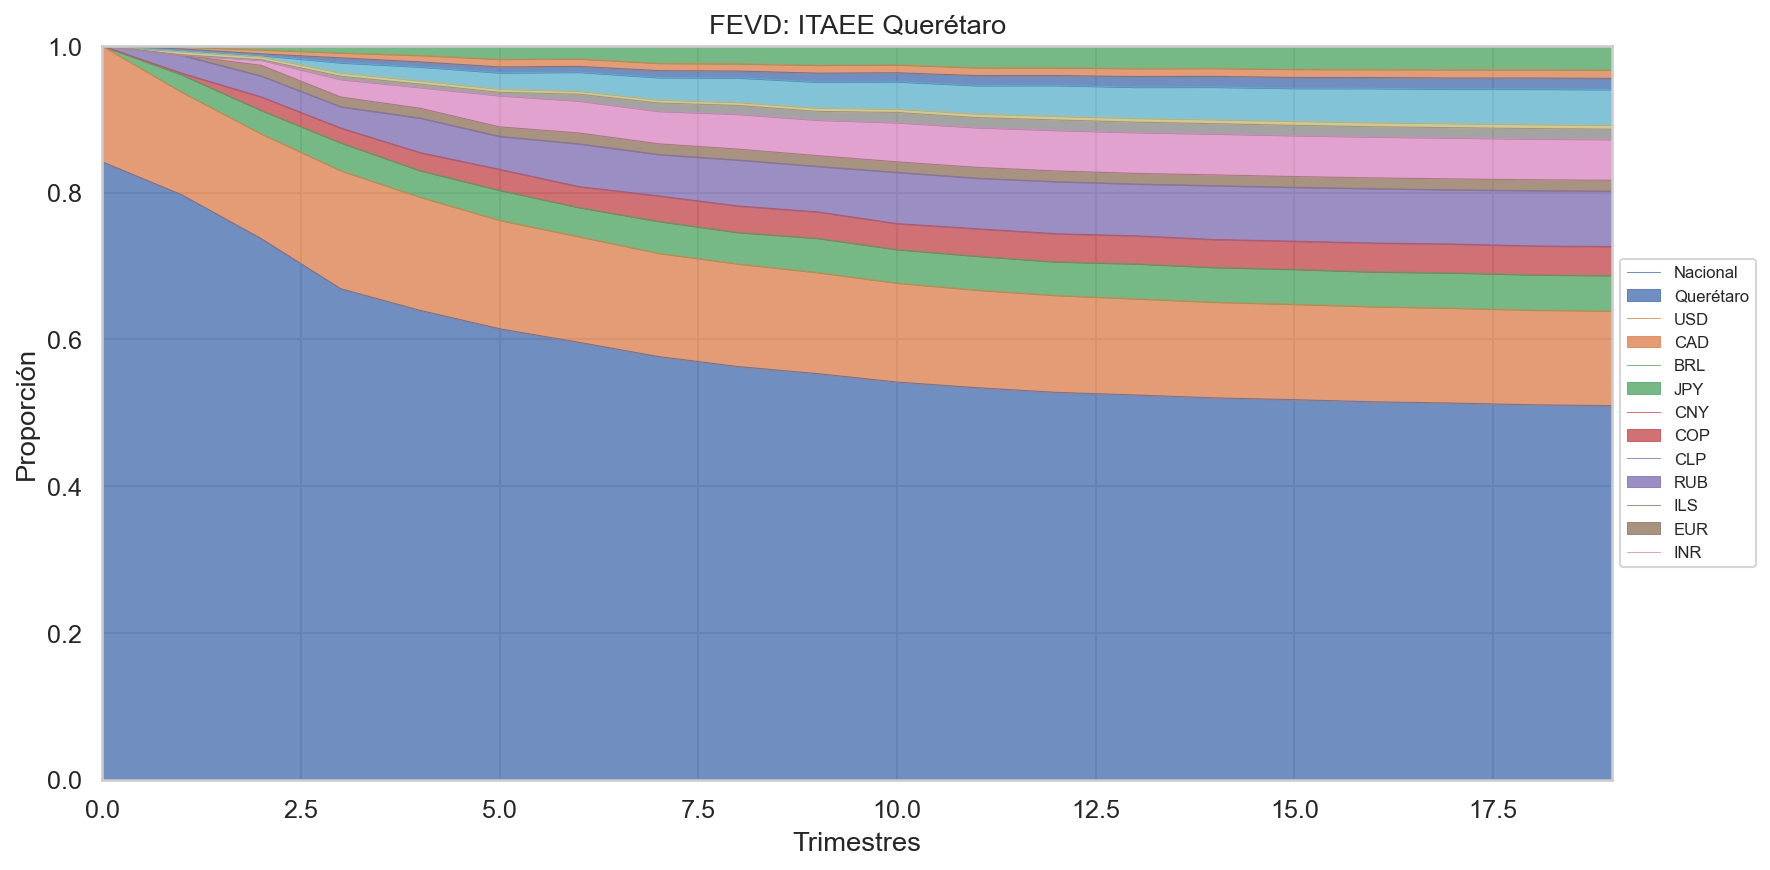


  ESTADO: San Luis Potosí

--- (a) Selección de rezagos ---
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -78.96     -78.53*  5.113e-35*     -78.79*
1      -78.07      -72.03   1.350e-34      -75.69
2      -77.47      -65.83   4.375e-34      -72.87
3     -81.03*      -63.77   7.983e-35      -74.21
-------------------------------------------------

→ Rezago seleccionado (AIC): p = 3

--- (b) VAR(3) estimado ---
   Observaciones usadas: 66
   Variables: 3 rezagos × 13 variables

--- (c) Diagnósticos ---
Durbin-Watson por ecuación:
   Nacional            : 1.979
   San Luis Potosí     : 2.068
   USD                 : 2.209
   CAD                 : 2.224
   BRL                 : 1.924
   JPY                 : 2.293
   CNY                 : 2.218
   COP                 : 2.191
   CLP                 : 2.073
   RUB                 : 2.176
   ILS                 : 1.979
   EUR      

/Users/marionomics/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


F-stat  p-value Significant (5%)
FX                                   
USD   1.286   0.2874               No
CAD   0.422   0.7381               No
BRL   0.372   0.7733               No
JPY   0.642   0.5908               No
CNY   1.386   0.2561               No
COP   0.133   0.9398               No
CLP   0.368   0.7765               No
RUB   0.044   0.9878               No
ILS   0.510   0.6770               No
EUR   0.335   0.7999               No
INR   1.794   0.1582               No

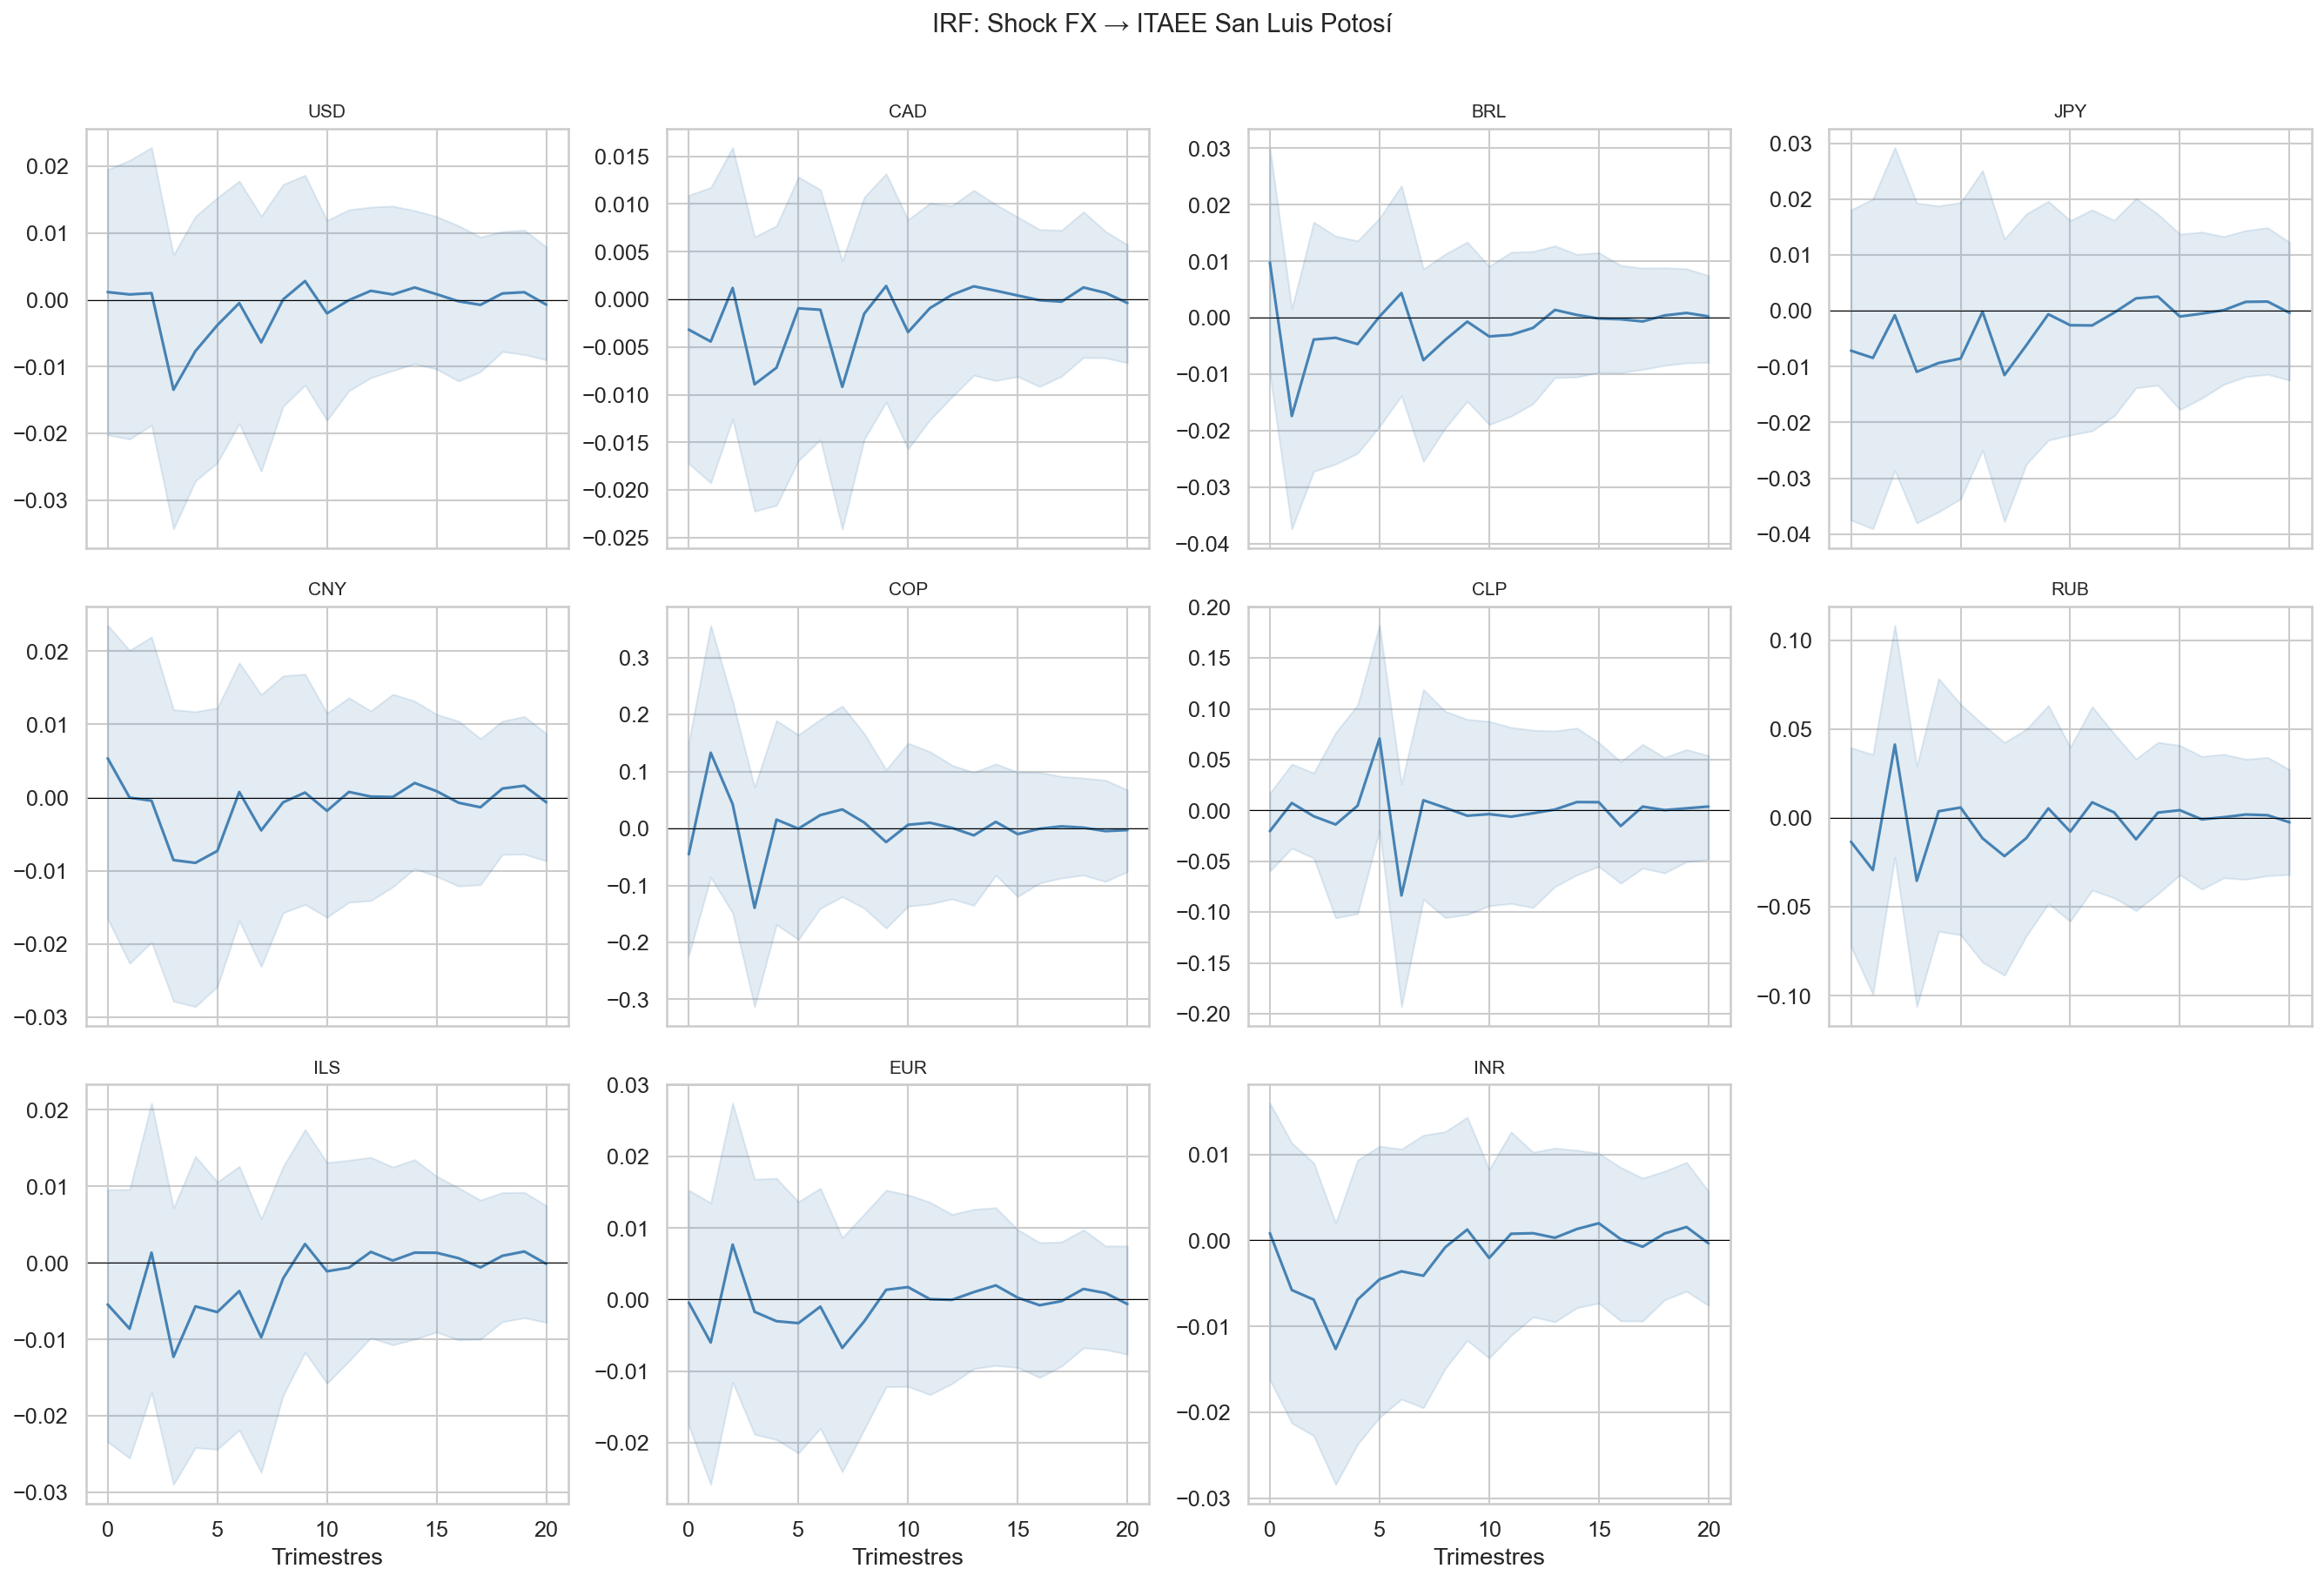

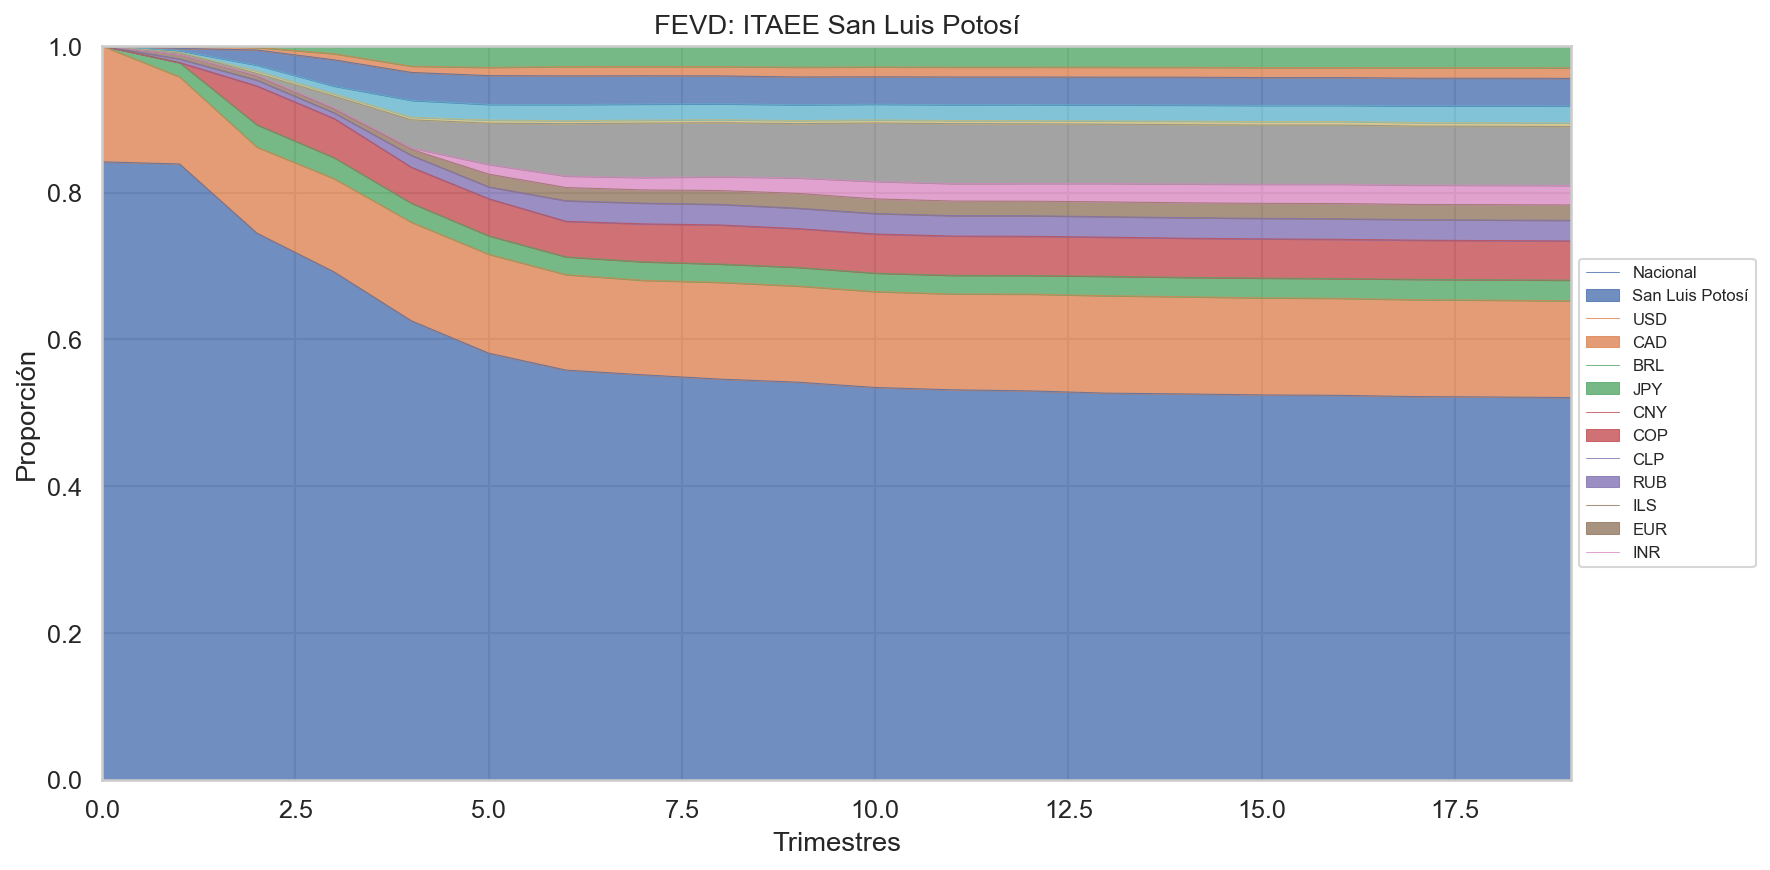


  ESTADO: Zacatecas

--- (a) Selección de rezagos ---
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -77.12     -76.69*   3.219e-34     -76.95*
1      -76.49      -70.45   6.604e-34      -74.10
2      -76.96      -65.31   7.318e-34      -72.36
3     -79.81*      -62.56  2.679e-34*      -73.00
-------------------------------------------------

→ Rezago seleccionado (AIC): p = 3

--- (b) VAR(3) estimado ---
   Observaciones usadas: 66
   Variables: 3 rezagos × 13 variables

--- (c) Diagnósticos ---
Durbin-Watson por ecuación:
   Nacional            : 2.050
   Zacatecas           : 2.094
   USD                 : 2.418
   CAD                 : 2.366
   BRL                 : 2.008
   JPY                 : 2.509
   CNY                 : 2.527
   COP                 : 1.958
   CLP                 : 1.989
   RUB                 : 2.253
   ILS                 : 2.260
   EUR            

/Users/marionomics/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


F-stat  p-value Significant (5%)
FX                                   
USD   0.010   0.9986               No
CAD   0.340   0.7963               No
BRL   1.902   0.1391               No
JPY   0.049   0.9855               No
CNY   0.296   0.8282               No
COP   0.299   0.8261               No
CLP   1.374   0.2595               No
RUB   0.214   0.8861               No
ILS   0.130   0.9417               No
EUR   0.277   0.8417               No
INR   0.454   0.7157               No

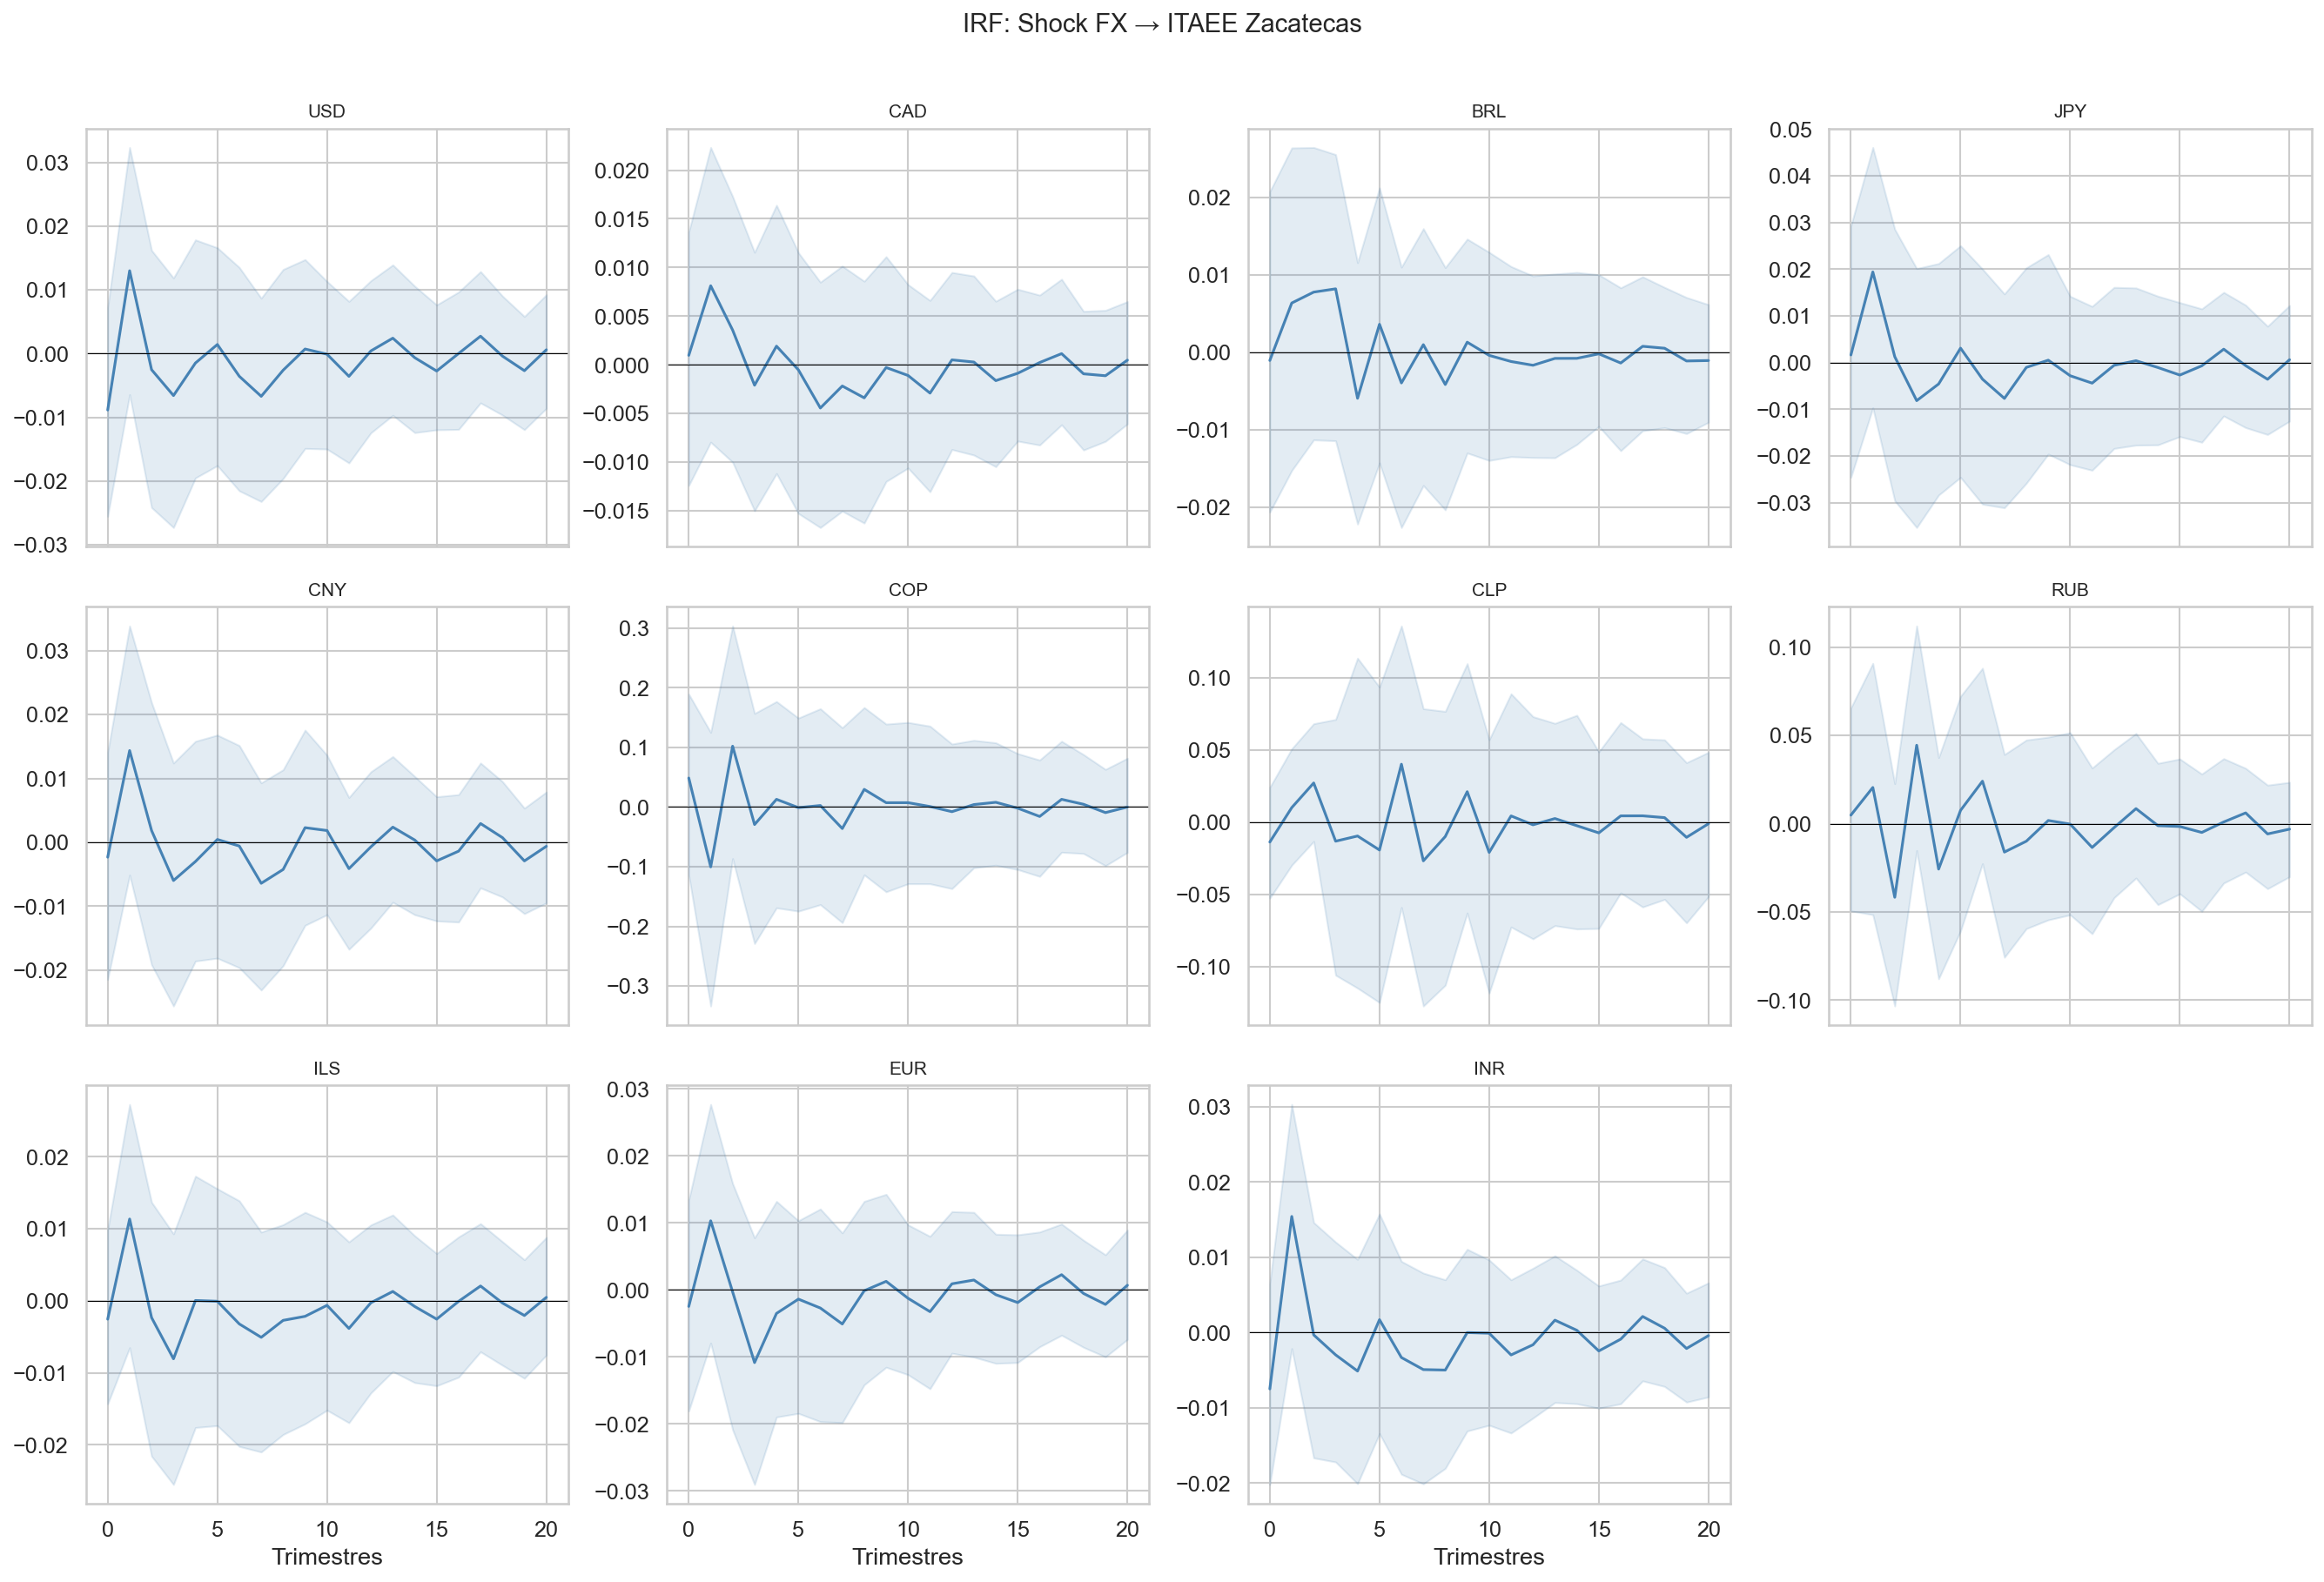

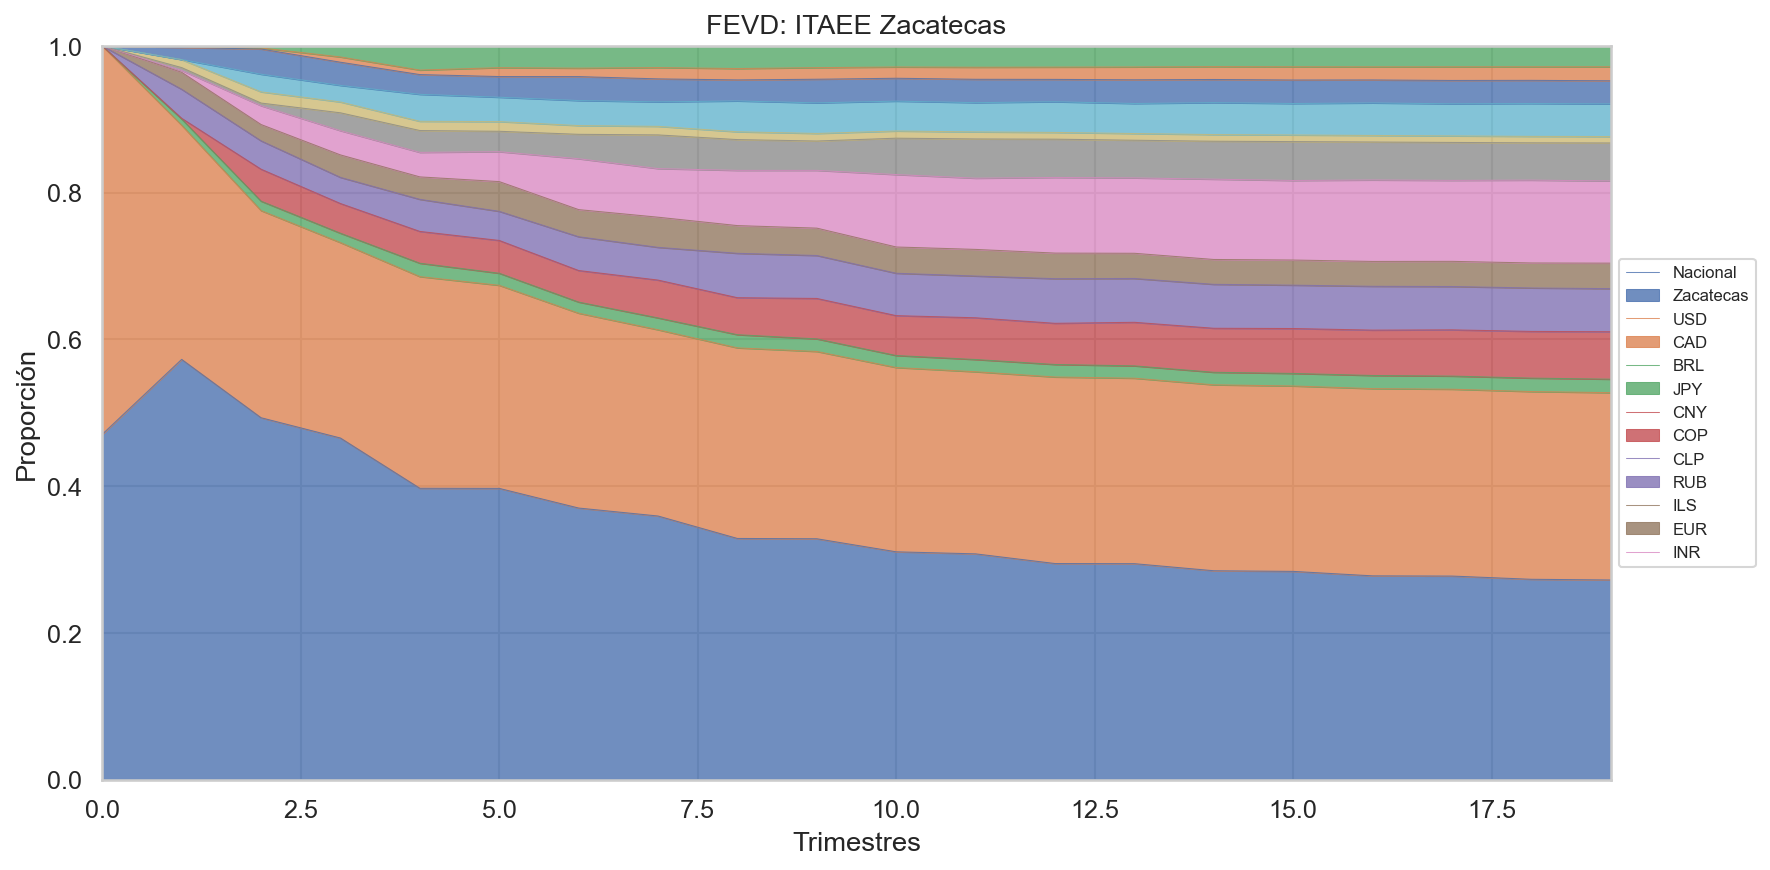

In [5]:
for state in states:
    print("=" * 80)
    print(f"  ESTADO: {state}")
    print("=" * 80)

    # Select 13 variables for this state
    var_cols = ["ITAEE_Nacional", f"ITAEE_{state}"] + fx_cols
    data = df_var[var_cols].copy()

    # ---------------------------------------------------------------
    # (a) Lag selection
    # ---------------------------------------------------------------
    model = VAR(data)
    lag_order = model.select_order(maxlags=MAX_LAGS)
    print("\n--- (a) Selección de rezagos ---")
    print(lag_order.summary())

    # Use AIC-selected lag (minimum 1)
    p = max(lag_order.aic, 1)
    print(f"\n→ Rezago seleccionado (AIC): p = {p}")

    # ---------------------------------------------------------------
    # (b) Model estimation
    # ---------------------------------------------------------------
    var_result = model.fit(p)
    print(f"\n--- (b) VAR({p}) estimado ---")
    print(f"   Observaciones usadas: {var_result.nobs}")
    print(f"   Variables: {var_result.k_ar} rezagos × {len(var_cols)} variables")

    # ---------------------------------------------------------------
    # (c) Diagnostic tests
    # ---------------------------------------------------------------
    print("\n--- (c) Diagnósticos ---")
    resid_vals = var_result.resid.values if hasattr(var_result.resid, 'values') else var_result.resid

    # Durbin-Watson per equation
    dw = durbin_watson(resid_vals)
    print("Durbin-Watson por ecuación:")
    for col_name, dw_val in zip(var_cols, dw):
        short = col_name.replace("ITAEE_", "").replace("FX_", "")
        print(f"   {short:20s}: {dw_val:.3f}")

    # Normality (Jarque-Bera per equation)
    print("\nJarque-Bera por ecuación:")
    for i, col_name in enumerate(var_cols):
        jb_stat, jb_p = jarque_bera(resid_vals[:, i])[:2]
        short = col_name.replace("ITAEE_", "").replace("FX_", "")
        flag = " *" if jb_p < 0.05 else ""
        print(f"   {short:20s}: JB={jb_stat:8.3f}  p={jb_p:.4f}{flag}")

    # Stability check (roots of characteristic polynomial, all |root| > 1 → stable)
    is_stable = var_result.is_stable()
    roots_mod = np.abs(var_result.roots)
    print(f"\nEstabilidad (todas las raíces fuera del círculo unitario): {is_stable}")
    print(f"   Módulo mínimo de raíces: {roots_mod.min():.4f}")

    # ---------------------------------------------------------------
    # (d) Granger causality
    # ---------------------------------------------------------------
    print(f"\n--- (d) Causalidad de Granger: FX → ITAEE_{state} ---")
    itaee_col = f"ITAEE_{state}"
    granger_rows = []
    for fx in fx_cols:
        pair_data = data[[itaee_col, fx]].dropna()
        try:
            gc = grangercausalitytests(pair_data, maxlag=p, verbose=False)
            f_stat = gc[p][0]["ssr_ftest"][0]
            f_pval = gc[p][0]["ssr_ftest"][1]
        except Exception:
            f_stat, f_pval = np.nan, np.nan
        granger_rows.append({
            "FX": fx.replace("FX_", ""),
            "F-stat": round(f_stat, 3),
            "p-value": round(f_pval, 4),
            "Significant (5%)": "Yes" if f_pval < 0.05 else "No",
        })
    gc_df = pd.DataFrame(granger_rows).set_index("FX")
    display(gc_df)

    # ---------------------------------------------------------------
    # (e) Impulse Response Functions
    # ---------------------------------------------------------------
    irf = var_result.irf(periods=20)
    irf_lower, irf_upper = irf.errband_mc(orth=True, repl=500, signif=0.05)

    itaee_idx = var_cols.index(itaee_col)
    n_fx = len(fx_cols)
    fig, axes = plt.subplots(3, 4, figsize=(18, 12), sharex=True)
    axes = axes.flatten()

    for j, fx in enumerate(fx_cols):
        fx_idx = var_cols.index(fx)
        ax = axes[j]
        resp = irf.orth_irfs[:, fx_idx, itaee_idx]
        lower = irf_lower[:, fx_idx, itaee_idx]
        upper = irf_upper[:, fx_idx, itaee_idx]
        horizons = np.arange(len(resp))

        ax.plot(horizons, resp, color="steelblue", linewidth=1.5)
        ax.fill_between(horizons, lower, upper, color="steelblue", alpha=0.15)
        ax.axhline(0, color="black", linewidth=0.5)
        ax.set_title(fx.replace("FX_", ""), fontsize=10)
        if j >= 8:
            ax.set_xlabel("Trimestres")

    for k in range(n_fx, len(axes)):
        axes[k].set_visible(False)

    fig.suptitle(f"IRF: Shock FX → ITAEE {state}", fontsize=14, y=1.01)
    plt.tight_layout()
    fig.savefig(os.path.join(FIG_DIR, f"var_irf_{state.lower().replace(' ', '_')}.png"))
    plt.show()

    # ---------------------------------------------------------------
    # (f) Forecast Error Variance Decomposition
    # ---------------------------------------------------------------
    fevd = var_result.fevd(periods=20)
    fevd_data = fevd.decomp[itaee_idx]
    fevd_df = pd.DataFrame(fevd_data, columns=var_cols)

    fig, ax = plt.subplots(figsize=(12, 6))
    fevd_df.plot.area(ax=ax, stacked=True, alpha=0.8, linewidth=0.5)
    ax.set_title(f"FEVD: ITAEE {state}")
    ax.set_xlabel("Trimestres")
    ax.set_ylabel("Proporción")
    ax.set_xlim(0, 19)
    ax.set_ylim(0, 1)
    ax.legend(
        [c.replace("ITAEE_", "").replace("FX_", "") for c in var_cols],
        loc="center left", bbox_to_anchor=(1.0, 0.5), fontsize=8,
    )
    plt.tight_layout()
    fig.savefig(os.path.join(FIG_DIR, f"var_fevd_{state.lower().replace(' ', '_')}.png"))
    plt.show()

    # Store results
    results[state] = {
        "model": var_result,
        "lag": p,
        "stable": is_stable,
        "granger": gc_df,
        "irf": irf,
        "fevd": fevd,
    }

    print()

## 4. Tabla Resumen Comparativa

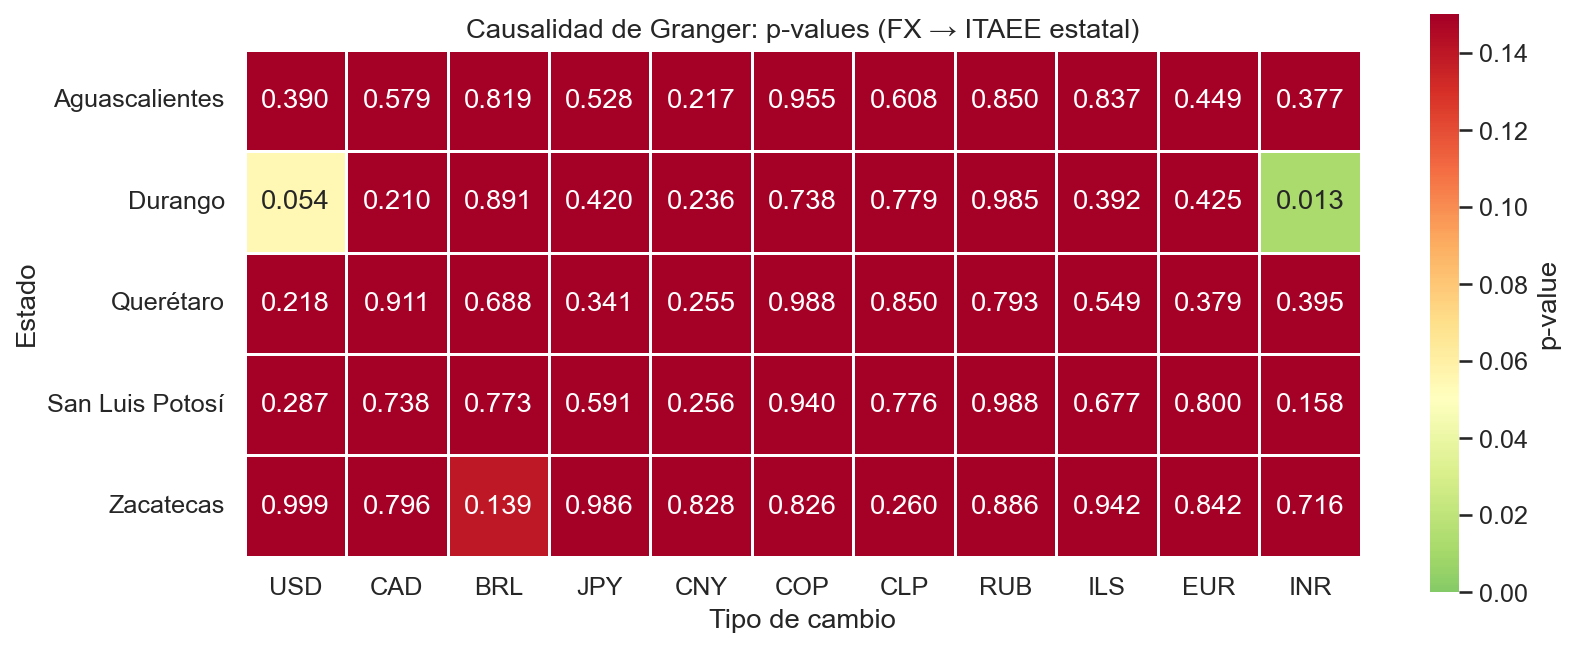

In [6]:
# --- Granger causality heatmap across all states ---
fx_short = [c.replace("FX_", "") for c in fx_cols]
granger_matrix = pd.DataFrame(index=states, columns=fx_short, dtype=float)

for state in states:
    gc_df = results[state]["granger"]
    for fx in fx_short:
        granger_matrix.loc[state, fx] = gc_df.loc[fx, "p-value"]

granger_matrix = granger_matrix.astype(float)

fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(
    granger_matrix,
    annot=True, fmt=".3f", cmap="RdYlGn_r",
    vmin=0, vmax=0.15, center=0.05,
    linewidths=0.5, square=True, ax=ax,
    cbar_kws={"label": "p-value"},
)
ax.set_title("Causalidad de Granger: p-values (FX → ITAEE estatal)")
ax.set_ylabel("Estado")
ax.set_xlabel("Tipo de cambio")
fig.savefig(os.path.join(FIG_DIR, "var_granger_heatmap.png"))
plt.show()

In [7]:
# --- Summary table: lag, stability, significant Granger causes ---
summary_rows = []
for state in states:
    r = results[state]
    sig_fx = r["granger"][r["granger"]["Significant (5%)"] == "Yes"].index.tolist()
    summary_rows.append({
        "Estado": state,
        "VAR Lag (p)": r["lag"],
        "Estable": r["stable"],
        "N° FX Granger-significativos": len(sig_fx),
        "FX significativos": ", ".join(sig_fx) if sig_fx else "—",
    })

summary_df = pd.DataFrame(summary_rows).set_index("Estado")
print("=== Resumen comparativo ===")
display(summary_df)

=== Resumen comparativo ===


VAR Lag (p)  Estable  N° FX Granger-significativos  \
Estado                                                                
Aguascalientes             3     True                             0   
Durango                    3     True                             1   
Querétaro                  3     True                             0   
San Luis Potosí            3     True                             0   
Zacatecas                  3     True                             0   

                FX significativos  
Estado                             
Aguascalientes                  —  
Durango                       INR  
Querétaro                       —  
San Luis Potosí                 —  
Zacatecas                       —

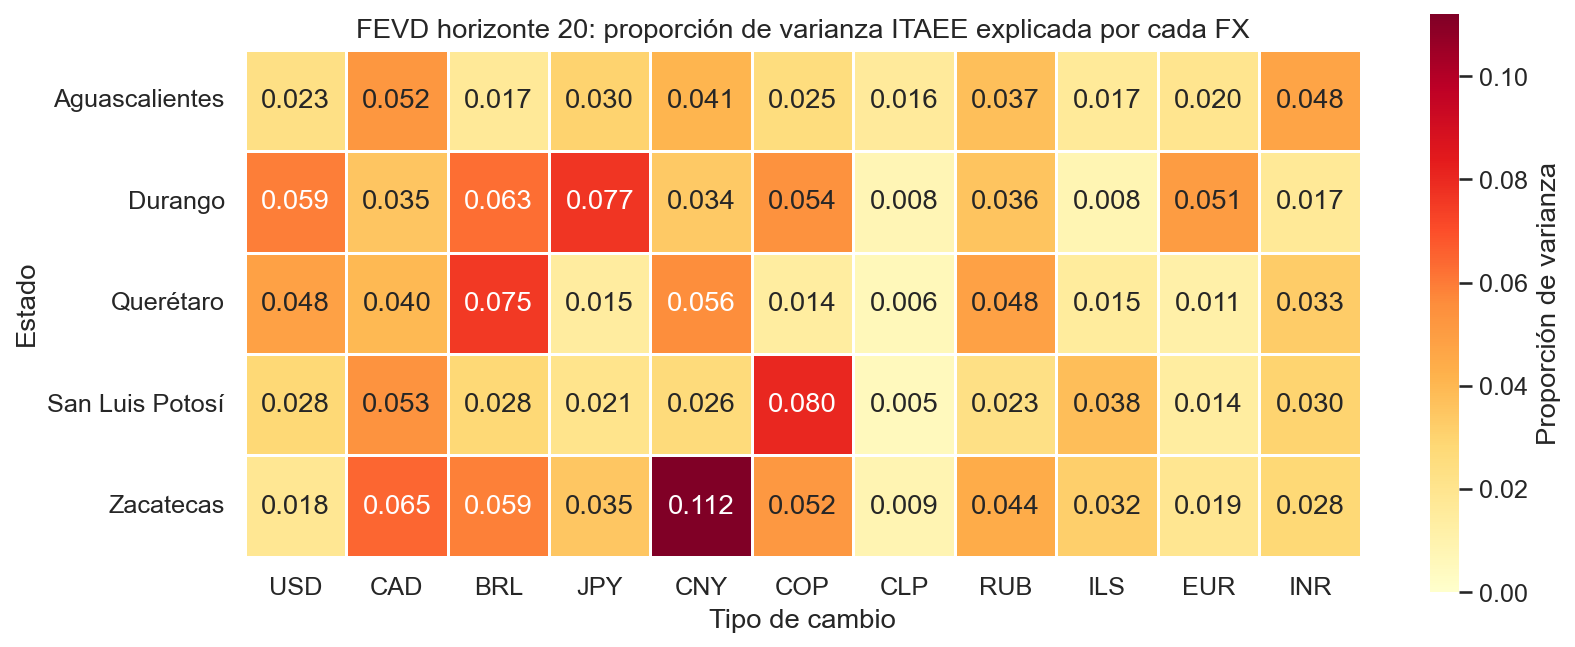


Figuras guardadas en: /Users/marionomics/Dropbox/trabajo/INVESTIGACION/PUBLICATIONS/PAPERS/Working/ITAEE/figures


In [8]:
# --- FEVD at horizon 20: share of ITAEE variance explained by each FX ---
fevd_h20 = pd.DataFrame(index=states, columns=fx_short, dtype=float)

for state in states:
    r = results[state]
    var_cols_state = ["ITAEE_Nacional", f"ITAEE_{state}"] + fx_cols
    itaee_idx = var_cols_state.index(f"ITAEE_{state}")
    decomp_20 = r["fevd"].decomp[itaee_idx][-1, :]  # last horizon
    for j, fx in enumerate(fx_cols):
        fx_idx = var_cols_state.index(fx)
        fevd_h20.loc[state, fx.replace("FX_", "")] = round(decomp_20[fx_idx], 4)

fevd_h20 = fevd_h20.astype(float)

fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(
    fevd_h20,
    annot=True, fmt=".3f", cmap="YlOrRd",
    vmin=0, vmax=fevd_h20.max().max(),
    linewidths=0.5, square=True, ax=ax,
    cbar_kws={"label": "Proporción de varianza"},
)
ax.set_title("FEVD horizonte 20: proporción de varianza ITAEE explicada por cada FX")
ax.set_ylabel("Estado")
ax.set_xlabel("Tipo de cambio")
fig.savefig(os.path.join(FIG_DIR, "var_fevd_heatmap.png"))
plt.show()

print("\nFiguras guardadas en:", FIG_DIR)

## 5. Exportar log de resultados

In [9]:
# Save a full results log for transparency and reproducibility
from datetime import datetime

log_path = os.path.join(os.path.dirname(os.getcwd()), "results", "var_results_log.txt")
os.makedirs(os.path.dirname(log_path), exist_ok=True)

with open(log_path, "w") as f:
    f.write("=" * 80 + "\n")
    f.write("VAR MODEL RESULTS LOG\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Data: {df.shape[0]} quarters, {df.index[0].date()} to {df.index[-1].date()}\n")
    f.write(f"Transformation: log-differences\n")
    f.write(f"Max lags considered: {MAX_LAGS}\n")
    f.write("=" * 80 + "\n\n")

    # --- Stationarity tests ---
    f.write("STATIONARITY TESTS (LEVELS)\n")
    f.write("-" * 80 + "\n")
    f.write(df_level.to_string() + "\n\n")

    f.write("STATIONARITY TESTS (LOG-DIFFERENCES)\n")
    f.write("-" * 80 + "\n")
    f.write(df_diff.to_string() + "\n\n")

    # --- Per-state results ---
    for state in states:
        r = results[state]
        var_res = r["model"]
        var_cols_state = ["ITAEE_Nacional", f"ITAEE_{state}"] + fx_cols
        rv = var_res.resid.values if hasattr(var_res.resid, 'values') else var_res.resid

        f.write("=" * 80 + "\n")
        f.write(f"STATE: {state}\n")
        f.write("=" * 80 + "\n\n")

        f.write(f"Selected lag (AIC): p = {r['lag']}\n")
        f.write(f"Observations used: {var_res.nobs}\n")
        f.write(f"Stable (all roots outside unit circle): {r['stable']}\n\n")

        # Durbin-Watson
        f.write("Durbin-Watson per equation:\n")
        dw = durbin_watson(rv)
        for col_name, dw_val in zip(var_cols_state, dw):
            short = col_name.replace("ITAEE_", "").replace("FX_", "")
            f.write(f"   {short:20s}: {dw_val:.3f}\n")
        f.write("\n")

        # Jarque-Bera
        f.write("Jarque-Bera per equation:\n")
        for i, col_name in enumerate(var_cols_state):
            jb_stat, jb_p = jarque_bera(rv[:, i])[:2]
            short = col_name.replace("ITAEE_", "").replace("FX_", "")
            flag = " *" if jb_p < 0.05 else ""
            f.write(f"   {short:20s}: JB={jb_stat:8.3f}  p={jb_p:.4f}{flag}\n")
        f.write("\n")

        # Granger causality
        f.write(f"Granger Causality: FX → ITAEE_{state}\n")
        f.write(r["granger"].to_string() + "\n\n")

        # FEVD at horizon 20
        itaee_idx = var_cols_state.index(f"ITAEE_{state}")
        decomp_20 = r["fevd"].decomp[itaee_idx][-1, :]
        f.write("FEVD at horizon 20 (variance share of state ITAEE):\n")
        for j, col_name in enumerate(var_cols_state):
            short = col_name.replace("ITAEE_", "").replace("FX_", "")
            f.write(f"   {short:20s}: {decomp_20[j]:.4f}\n")
        f.write("\n")

    # --- Cross-state summary ---
    f.write("=" * 80 + "\n")
    f.write("CROSS-STATE SUMMARY\n")
    f.write("=" * 80 + "\n\n")

    f.write("Summary table:\n")
    f.write(summary_df.to_string() + "\n\n")

    f.write("Granger causality p-values (FX → state ITAEE):\n")
    f.write(granger_matrix.to_string() + "\n\n")

    f.write("FEVD at horizon 20 (FX share of state ITAEE variance):\n")
    f.write(fevd_h20.to_string() + "\n\n")

    f.write("=" * 80 + "\n")
    f.write("END OF LOG\n")
    f.write("=" * 80 + "\n")

print(f"Results log saved to: {log_path}")

Results log saved to: /Users/marionomics/Dropbox/trabajo/INVESTIGACION/PUBLICATIONS/PAPERS/Working/ITAEE/results/var_results_log.txt
